In [3]:
'''
IV. 앙상블 학습
    - 랜덤포레스트, 그래디언트 부스팅, XGBoost, LightGBM, 스태킹
    - 학습유형은 보팅, 배깅, 부스팅으로 나뉨; 보팅과 배깅은 분류기가 투표를 통해 예측 결과를 저장한다는 공통점이 있지만, 보팅과 달리 배깅은 각각의 분류기가 같은 유형의 알고리즘 기반(데이터 샘플링만 다르게 함 : 부트스트래핑)
    - 부스팅은 여러 개의 분류기가 순차적으로 학습을 수행하되, 앞에서 학습한 분류기가 예측이 틀린 데이터에 대해서 올바르게 예측할 수 있도록 다음 분류기에 가중치를 부여하면서 학습과 예측 진행
    - 스태킹은 여러가지 다른 모델의 예측 결괏값을 다시 학습데이터로 만들어서 다른 모델로 재학습, 결과 예측
    - 보팅 방식의 앙상블을 sklearn에서 VotingClassifier 로 구현
'''

import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer # 위스콘신 유방암 데이터 세트
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
# 로지스틱 회귀와 KNN으로 보팅 앙상블 구현
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier()

# 개별 모델을 소프트 보팅 기반의 앙상블로 구현
vo_clf = VotingClassifier(estimators = [('LR', lr_clf), ('KNN', knn_clf)], voting = 'soft') # voting 디폴트 값은 hard

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

#학습, 예측, 평가
vo_clf.fit(X_train,y_train)
pred = vo_clf.predict(X_test)
print('보팅 앙상블 정확도 :',accuracy_score(y_test, pred))

#개별 모델 학습, 예측, 평가
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    print(classifier, '정확도 :', accuracy_score(y_test, pred))

보팅 앙상블 정확도 : 0.9473684210526315
LogisticRegression() 정확도 : 0.9385964912280702
KNeighborsClassifier() 정확도 : 0.9035087719298246


C:\Users\1\anaconda3\envs\virtualtensor3.7\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\1\anaconda3\envs\virtualtensor3.7\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

In [8]:
'''
IV.랜덤 포레스트
    - 같은 알고리즘(주로 의사결정트리)으로 여러개의 분류기를 만들어 보팅하는 배깅 방식
    - 여러개의 의사결정트리가 전체 데이터에서 각자 데이터를 (중복되게) 샘플링해(부트스트래핑) 서로 다르게 학습됨
    - 사이킷런은 RandomForestClassifier 클래스를 통해 랜덤포레스트 지원
'''
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x : x[0] + '_' + str(x[1]) if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset():
    
    feature_name_df = pd.read_csv('features.txt', sep='\s+', header=None, names = ['column_index','column_name'])
    
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    X_train = pd.read_csv('X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('X_test.txt', sep='\s+', names=feature_name)
    
    y_train = pd.read_csv('y_train.csv', names=['action'])
    y_test = pd.read_csv('y_test.csv', names=['action'])
    
    return X_train, X_test, y_train, y_test

from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

#데이터 로딩
X_train, X_test, y_train, y_test = get_human_dataset()

#랜덤 포레스트 학습 및 예측
rf_clf = RandomForestClassifier(random_state = 0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
print(accuracy_score(y_test, pred))

0.9253478113335596


In [9]:
'''
    1. 랜덤 포레스트 하이퍼 파라미터 및 튜닝
        - n_estimator : 랜덤 포레스트에서 사용되는 결정 트리의 개수 지정(디폴트 10개)
        - max_feature : 결정트리에서의 max_feature와 같은 but 디폴트는 None이 아니라 auto(=sqrt)
        - max_depth, min_samples_leaf 등 모두 같음
'''

# GridSearchCV 를 이용, 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : [10],
    'max_depth' : [6,8,10],
    'min_samples_leaf' : [8,12,18],
    'min_samples_split' : [8,16,20]
}

rf_clf = RandomForestClassifier(random_state = 0, n_jobs=-1) # n_jobs = -1 옵션을 이용하면 모든 CPU 코어를 이용해 학습, 시간 단축
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 2, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print(grid_cv.best_params_)
print(grid_cv.best_score_)

{'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 10}
0.9026115342763874


In [10]:
#예측

pred = grid_cv.best_estimator_.predict(X_test)
print(accuracy_score(y_test, pred))

0.8965049202578894


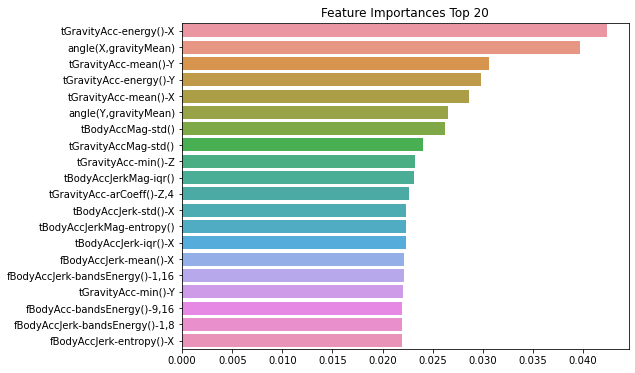

In [11]:
#피처 중요도 시각화
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = grid_cv.best_estimator_.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature Importances Top 20')
sns.barplot(x=ftr_top20, y = ftr_top20.index)
plt.show()

In [12]:
'''
V. GBM(Gradient Boosting Machine)
    - 여러개의 약한 학습기를 순차적으로 학습, 예측하면서 잘못 예측한 데이터에 가중치를 부여, 오류를 개선하는 것이 에이다 부스트
    - 그래디언트 부스트는 에이다부스트에서 가중치를 업데이트 하는 과정에 경사하강법을 적용
    - 사이킷런에서 GradientBoostingClassifier 클래스를 통해 제공
'''

from sklearn.ensemble import GradientBoostingClassifier
import time #학습에 걸리는 시간을 측정하기 위한 모듈
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

#시작 시간 설정
start_time = time.time()
gb_clf = GradientBoostingClassifier(random_state = 0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)

print(accuracy_score(y_test, gb_pred))
print('수행 시간 :', time.time() - start_time) # 정확성은 랜덤포레스트보다 다소 높지만 학습시간이 오래 걸린다는 단점

0.9385816084153377
수행 시간 : 1117.9112396240234


In [14]:
'''
    (1) GBM 하이퍼 파라미터 및 튜닝
        - n_estimators(weak learner의 개수, 기본값 100), max_depth, max_features
        - loss : 비용함수 지정, 특별한 이유가 없으면 디폴트인 deviance
        - learning_rate : 기본값은 0.1
        - subsample : weak learner가 학습에 사용하는 데이터의 샘플링 비율, 기본값 1(전체 학습 데이터를 기반으로 학습), 과적합 염려시 subsample을 1보다 자은 값으로 설정
'''

# GridSearchCV를 이용한 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : [30,50],
    'learning_rate' : [0.1, 0.2]
}

grid_cv = GridSearchCV(gb_clf, param_grid = params, cv = 2, verbose = 1)
grid_cv.fit(X_train, y_train)
print('최적 하이퍼 파라미터 :', grid_cv.best_params_)
print(grid_cv.best_score_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 27.9min finished


최적 하이퍼 파라미터 : {'learning_rate': 0.2, 'n_estimators': 50}
0.8998911860718172


In [16]:
# 예측
gb_pred = grid_cv.best_estimator_.predict(X_test)
print(accuracy_score(y_test, gb_pred))

0.9362063115032236


In [18]:
'''
VI. XGBoost(eXtra Gradient Boost)
    - GBM기반, GBM의 느린 수행 시간 및 과적합 규제 부재 등을 해결
    - 병렬 CPU 환경에서 병렬 학습 가능 
    - 교차 검증 자체 내장, 결손값 자체 처리
    
    (1) XGBoost 설치하기
        - 아나콘다 프롬프트에서 conda install -c anaconda py-xgboost(윈도우)
        - conda install -c conda-forge xgboost(리눅스)
'''
import xgboost as xgb
from xgboost import XGBClassifier

In [21]:
'''
    (2) 파이썬 래퍼 XGBoost 하이퍼 파라미터
        - XGBoost는 원래 C언어 기반 -> 파이썬으로 연결만 시킨것이 파이썬 래퍼 XGBoost ; 사이킷런과 연동시킨 것이 사이킷런 래퍼 XGBoost
        - 사이킷런의 하이퍼 파라미터와 기능은 같지만 이름이 다름 
        
        (i) 주요 일반 파라미터
            - booster : gbtree(tree based model) 또는 gblinear(linear model) 중 선택, 디폴트는 gbtree
            - silent : 디폴트는 0, 출력 메세지를 나타내고 싶지 않을 경우 1
            - nthread : CPU의 실행 스레드 개수 조정, 디폴트는 전체 CPU 스레드 개수
        
        (ii) 주요 부스터 파라미터
            - eta : GBM의 learning rate, 파이썬 래퍼는 디폴트 0.3, 사이킷런 래퍼는 디폴트 0.1, 이름은 learning_rate
            - num_boost_rounds : GBM의 n_estimators
            - min_child_weight : 트리에서 추가적으로 가지를 나눌지 결정, 디폴트 1
            - gamma : 트리의 리프노드를 추가적으로 나눌지 결정할 최소 손실 감소 값, 디폴트 0
            - max_delpth : 디폴트 6, 0 지정 시 깊이 제한 X
            - sub_sample : GBM의 subsample, 디폴트 1
            - colsample_bytree : GBM의 max_feature, 디폴트 1
            - lambda : 디폴트 1, L2 Regularization 적용 값, 값이 클수록 과적합 감소 효과
            - alpha : 디폴트 0, L1 Regularization 적용 값, 값이 클수록 과적합 감소 효과
            - scale_pos_weight : 특정값으로 치우친 비대칭 데이터의 균형을 유지하기 위한 파라미터
        
        (iii) 학습 태스크 파라미터
            - objective : 최솟값을 가져야할 손실함수 정의
            - binary:logistic : 이진 분류일 때 적요
            - multi:softmax : 다중 분류 일 때 적용, num_class 파라미터 지정
            - multi:softprob : multi:softmax와 유사하나 개별 레이블 클래스의 해당되는 예측 확률 반환
            - eval_metric : 검증에 사용되는 함수 정의, 기본값은 회귀의 경우 rmse, 분류일 경우 error ; rmse, mae(mean absolute error), logloss, error, merror, mlobloss, auc
        
        - 과적합 문제가 심각할 시 eta값 낮추기(num_round는 반대로 높이기), max_depth 낮추기, min_child_weight 높이기, gamma 높이기, subsample 등 조절
'''

print(xgb.__version__)

0.90


In [23]:
# 파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측
import xgboost as xgb
from xgboost import plot_importance # 중요성 시각화해주는 모듈
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_feature = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data = X_feature, columns = dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [24]:
# 양성(1)과 악성(0)의 분포 확인
print(cancer_df['target'].value_counts())

1    357
0    212
Name: target, dtype: int64


In [26]:
#데이터 분할
X_train,X_test,y_train,y_test = train_test_split(X_feature, y_label, test_size = 0.2, random_state=156)

# XGBoost의 데이터셋 타입인 Dmatrix 생성 -> 주로 넘파이를 인자로 받음
dtrain = xgb.DMatrix(data = X_train, label = y_train)
dtest = xgb.DMatrix(data = X_test, label = y_test)

In [29]:
# 하이퍼 파라미터 설정
params = {'max_depth' : 3,
          'eta' : 0.1,
          'objective' : 'binary:logistic',
          'early_stoppings' : 100 #조기종료 설정 -> 100번동안 error가 감소하지 않으면 학습 종료
         }
num_rounds = 400

#모델 학습
# train 데이터 세트는 'train', test 데이터 세트는 'eval'로 명기
wlist = [(dtrain, 'train'), (dtest, 'eval')]
#하이퍼 파라미터 설정
xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = num_rounds, early_stopping_rounds = 100, evals=wlist) 
# early_stopping_rounds 파라미터로 조기중단 설정, eval_set과 eval_metric을 반드시 함께 설정
# eval_set은 성능 평가를 수행할 평가용 데이터 세트 설정, eval_metric은 평가 세트에 적용할 성능평가 방법

[0]	train-error:0.030769	eval-error:0.052632
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 100 rounds.
[1]	train-error:0.026374	eval-error:0.061404
[2]	train-error:0.017582	eval-error:0.052632
[3]	train-error:0.021978	eval-error:0.061404
[4]	train-error:0.013187	eval-error:0.052632
[5]	train-error:0.013187	eval-error:0.052632
[6]	train-error:0.013187	eval-error:0.052632
[7]	train-error:0.013187	eval-error:0.052632
[8]	train-error:0.013187	eval-error:0.052632
[9]	train-error:0.013187	eval-error:0.052632
[10]	train-error:0.015385	eval-error:0.052632
[11]	train-error:0.013187	eval-error:0.052632
[12]	train-error:0.015385	eval-error:0.052632
[13]	train-error:0.013187	eval-error:0.052632
[14]	train-error:0.010989	eval-error:0.052632
[15]	train-error:0.010989	eval-error:0.052632
[16]	train-error:0.008791	eval-error:0.052632
[17]	train-error:0.008791	eval-error:0.052632
[18]	train-error:0.008791	eval-error

In [30]:
# 예측
pred_probs = xgb_model.predict(dtest) #사이킷런의 predict()가 0 또는 1의 값을 반환하는데 반해 xgboost의 predict()는 확률을 반환
print(np.round(pred_probs[:10], 3))

[0.875 0.003 0.934 0.173 0.987 1.    0.999 0.998 0.996 0.   ]


In [31]:
#예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
print(preds[:10])

[1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [33]:
# 정확도
print(accuracy_score(y_test, preds))

0.9649122807017544


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

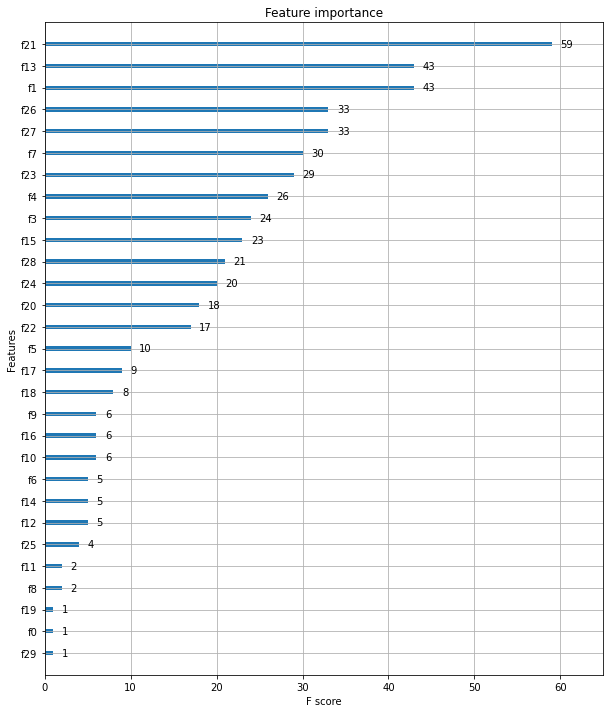

In [34]:
# XGBoost에 내장된 시각화 기능 수행
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax) #f21은 21번째 피처를 의미

In [6]:
'''
        - 트리 구조의 시각화는 xgboost.to_graph-viz(모델객체, 파일명)
        - GridSearchCV와 유사한 기능을 하는 방법은 xgboost.cv(params, dtrain, num_boost_round=10,nfold=3, metrics = () ...) #metrics()는 사용할 성능지표, 반환값은 DataFrame

    (3) 사이킷런 래퍼 XGBoost의 개요 및 적용
        - 사이킷런의 기본 Estimator를 그대로 상속해 fit(), predict()를 동일하게 사용 가능, GridSearchCV, pipeline 등 유틸리트 호환 가능
        - 분류는 XGBClassifier, 회귀는 XGBRegressor 클래스 사용
        - eta -> learning_rate, sub_sample -> subsample, lambda -> reg_lambda, alpha -> reg_alpha로 파라미터 명 변경
        
'''

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

dataset = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size = 0.2, random_state = 156)

from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimator = 400, learning_rate = 0.1, max_depth = 3 ) #위와 동일하게 하이퍼파라미터 설정
xgb_wrapper.fit(X_train, y_train)
pred = xgb_wrapper.predict(X_test)
print(accuracy_score(y_test, pred))

0.956140350877193


In [7]:
# 조기 중단 설정
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'logloss', eval_set = evals, verbose = True) # 조기중단을 하려면 fit()에서 옵션 3개 추가로 설정
ws100_preds = xgb_wrapper.predict(X_test)
print(accuracy_score(y_test, ws100_preds))

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

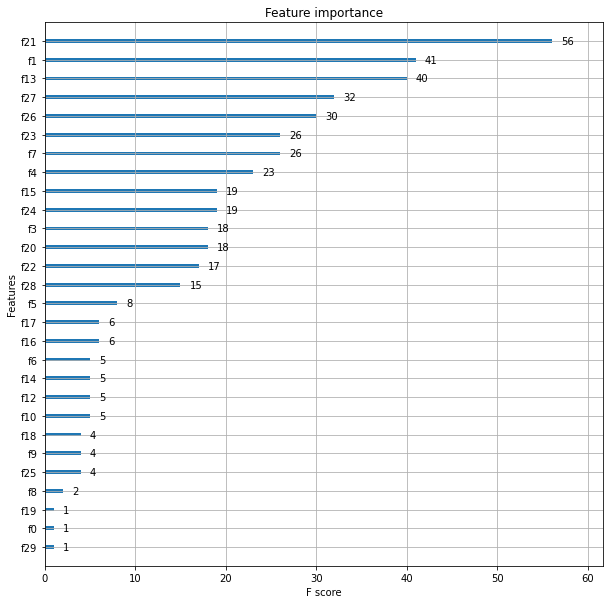

In [12]:
# 시각화는 파이썬래퍼의 방식과 동일
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10,10))
plot_importance(xgb_wrapper, ax=ax)

In [16]:
'''
VII.  LightGBM
    - XGBoost보다 학습에 걸리는 시간이 훨씬 적고, 메모리 사용량도 적지만 예측능력은 비슷
    - 적은 데이터셋의 경우 과적합이 발생하기 쉽다는 단점 ; 적은 데이터 셋은 10000건 이하의 데이터셋을 의미
    
    (1) LightGBM 설치
        - conda install -c conda-forge lightgbb ; 비주얼 스튜디오 빌드 툴 2015 이상의 버전 필요

    (2) LightGBM 하이퍼 파라미터
        - LightGBM은 트리가 계속 깊어지는 리프중심트리분할 -> 이에 맞는 하이퍼 파라미터 튜닝 필요
        (i) 주요 파라미터
            - num_iterations : 반복 수행하려는 트리 개수, 디폴트 100, 값이 커질수록 과적합, 사이킷런에서의 n_estimators
            - learning_rate : 디폴트 0.1
            - max_depth : 디폴트 1
            - min_data_in_leaf : 디폴트 20, 결정트리의 min_samples_leaf, 사이킷런에서 min_child_samples
            - num_leaves : 하나의 트리가 가질 수 있는 최대 리프 개수, 디폴트 3
            - boosting : 부스팅의 트리를 생성하는 알고리즘, 디폴트 gbdt(그래디언트 부스팅 결정 트리), rt(랜덤 포레스트)
            - bagging_fraction : 트리가 커져서 과적합 되는 것을 제어하기 위해 데이터를 샘플링하는 비율, 디폴트 1.0, 사이킷런에서 subsample
            - feature_fraction : 개별 트리를 학습할 때마다 무작위로 선택하는 피처 비율, 과적합을 방지하기위해 사용, 디폴트 1.0, GBM의 max_features와 유사 사이킷런에서 colsample_bytree
            - lambda_l2 : L2 regulation 제어값, 디폴트 0 ; reg_lambda
            - labmda_01 : L1 regulation 제어값, 디폴트 0 ; reg_alpha
        (ii) Learning Task 파라미터
            - objective : 손실함수 지정
        
    (3) 하이퍼 파라미터 튜닝 방안
        - num_leaves 개수를 중심으로 min_data_in_leaf, max_depthㅡㄹ 함께 조정하면서 모델의 복잡도를 줄이는 것
'''
# LightGBM 적용 - 위스콘신 유방암 예측
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size = 0.2, random_state=156)

lgbm_wrapper = LGBMClassifier(n_estimators=400)

#조기중단 설정
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss',eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
print(accuracy_score(y_test, preds))

[1]	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_loglo

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

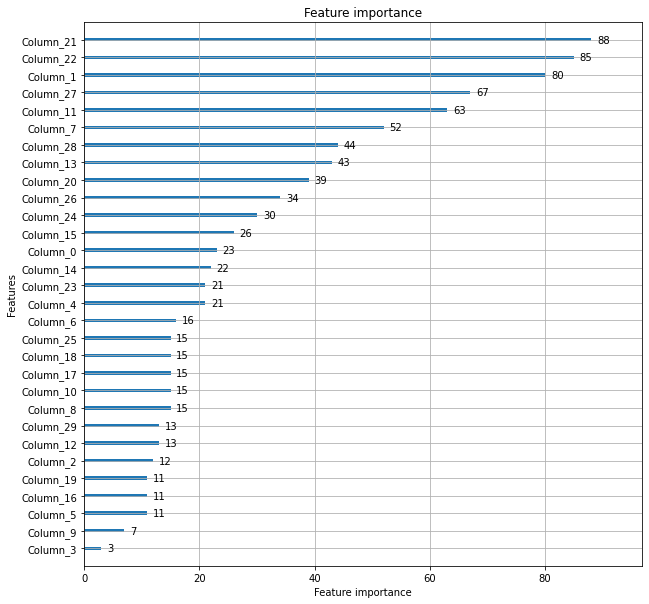

In [18]:
# 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,10))
plot_importance(lgbm_wrapper, ax=ax)

In [21]:
'''
VIII. 분류 실습 - 캐글 산탄데르 고객 만족 예측
    - 비대칭 데이터로 ROC-AUC로 평가
    - https://www.kaggle.com/c/santander-customer-satisfaction/data
'''

#데이터 전처리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv('santander_train.csv', encoding='latin-1')
print(cust_df.shape)
cust_df.head()

(76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [22]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [23]:
print(cust_df['TARGET'].value_counts())
# 불만족 비율 계산
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print(unsatisfied_cnt/total_cnt)

0    73012
1     3008
Name: TARGET, dtype: int64
0.0395685345961589


In [24]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [27]:
#var3 칼럼의 결측치값인 -999999 를 가장 많은 값인 2로 변환
#ID는 단순피처이므로 드롭

cust_df['var3'].replace(-999999, 2, inplace = True)
cust_df.drop('ID', axis=1, inplace = True)

#피처와 레이블 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]

#데이터셋 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size = 0.2, random_state = 0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 데이터 레이블 값 분포비율')
print(y_train.value_counts()/train_cnt)
print('테스트 데이터 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 데이터 레이블 값 분포비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64
테스트 데이터 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [28]:
#XGBoost 모델 학습과 하이퍼 파라미터 튜닝
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb_clf = XGBClassifier(n_estimator=500, random_state=156)

#성능 평가 지표를 auc로, 조기 중단 파리미터는 100으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric = 'auc', eval_set=[(X_train,y_train),(X_test, y_test)])

[0]	validation_0-auc:0.799928	validation_1-auc:0.803548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.802222	validation_1-auc:0.805222
[2]	validation_0-auc:0.80819	validation_1-auc:0.813162
[3]	validation_0-auc:0.8127	validation_1-auc:0.813243
[4]	validation_0-auc:0.81648	validation_1-auc:0.816979
[5]	validation_0-auc:0.816018	validation_1-auc:0.816629
[6]	validation_0-auc:0.816474	validation_1-auc:0.817776
[7]	validation_0-auc:0.818148	validation_1-auc:0.818464
[8]	validation_0-auc:0.81806	validation_1-auc:0.818295
[9]	validation_0-auc:0.817039	validation_1-auc:0.818087
[10]	validation_0-auc:0.818318	validation_1-auc:0.818749
[11]	validation_0-auc:0.818711	validation_1-auc:0.818521
[12]	validation_0-auc:0.818673	validation_1-auc:0.818516
[13]	validation_0-auc:0.819156	validation_1-auc:0.818998
[14]	validation_0-auc:0.819847	validation_1-auc:0.81999
[15

AttributeError: 'XGBClassifier' object has no attribute 'predict_prob'

In [32]:
print(roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro'))

0.841459212460676


In [33]:
# XGBoost 하이퍼 파라미터 튜닝 수행
# 학습시간이 많이 필요한 ML모델인 경우 한번에 모든 파라미터를 튜닝하는 것이 아니라 2~3개 먼저 튜닝 후 찾은 파라미터를 기반으로 1~2개씩 추가적으로 튜닝

from sklearn.model_selection import GridSearchCV

#테스트 수행속도를 향상시키기 위해 n_estimator를 100으로 감소
xgb_clf = XGBClassifier(n_estimator=100)

params = {'max_depth' : [5,7], 'min_child_weight' : [1,3], 'colsample_bytree' : [0.5, 0.75]}

#cv = 3 으로 지정
gridcv = GridSearchCV(xgb_clf, param_grid = params, cv = 3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc',eval_set=[(X_train, y_train), (X_test, y_test)])
print('최적 파라미터 :', gridcv.best_params_)
print(roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro'))

[0]	validation_0-auc:0.715421	validation_1-auc:0.722463
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.802772	validation_1-auc:0.807648
[2]	validation_0-auc:0.800147	validation_1-auc:0.804566
[3]	validation_0-auc:0.805692	validation_1-auc:0.809325
[4]	validation_0-auc:0.814807	validation_1-auc:0.816951
[5]	validation_0-auc:0.810346	validation_1-auc:0.812634
[6]	validation_0-auc:0.810623	validation_1-auc:0.814491
[7]	validation_0-auc:0.818556	validation_1-auc:0.820561
[8]	validation_0-auc:0.822006	validation_1-auc:0.823553
[9]	validation_0-auc:0.820433	validation_1-auc:0.821292
[10]	validation_0-auc:0.826212	validation_1-auc:0.825279
[11]	validation_0-auc:0.830077	validation_1-auc:0.827817
[12]	validation_0-auc:0.832328	validation_1-auc:0.828775
[13]	validation_0-auc:0.832008	validation_1-auc:0.827865
[14]	validation_0-auc:0.830319	validation_1-auc:0.82674

[51]	validation_0-auc:0.86387	validation_1-auc:0.843007
[52]	validation_0-auc:0.864428	validation_1-auc:0.843608
[53]	validation_0-auc:0.86492	validation_1-auc:0.843887
[54]	validation_0-auc:0.865341	validation_1-auc:0.844128
[55]	validation_0-auc:0.865713	validation_1-auc:0.843955
[56]	validation_0-auc:0.866165	validation_1-auc:0.844301
[57]	validation_0-auc:0.866538	validation_1-auc:0.84439
[58]	validation_0-auc:0.86671	validation_1-auc:0.844055
[59]	validation_0-auc:0.866977	validation_1-auc:0.843974
[60]	validation_0-auc:0.867483	validation_1-auc:0.8439
[61]	validation_0-auc:0.867853	validation_1-auc:0.843561
[62]	validation_0-auc:0.86811	validation_1-auc:0.843594
[63]	validation_0-auc:0.868319	validation_1-auc:0.843498
[64]	validation_0-auc:0.868554	validation_1-auc:0.843615
[65]	validation_0-auc:0.869021	validation_1-auc:0.843756
[66]	validation_0-auc:0.869095	validation_1-auc:0.843781
[67]	validation_0-auc:0.869277	validation_1-auc:0.843635
[68]	validation_0-auc:0.869639	validat

[1]	validation_0-auc:0.804027	validation_1-auc:0.809028
[2]	validation_0-auc:0.796929	validation_1-auc:0.805684
[3]	validation_0-auc:0.80379	validation_1-auc:0.811591
[4]	validation_0-auc:0.811904	validation_1-auc:0.818375
[5]	validation_0-auc:0.808826	validation_1-auc:0.815714
[6]	validation_0-auc:0.809236	validation_1-auc:0.816054
[7]	validation_0-auc:0.818354	validation_1-auc:0.823376
[8]	validation_0-auc:0.822085	validation_1-auc:0.826164
[9]	validation_0-auc:0.82165	validation_1-auc:0.824633
[10]	validation_0-auc:0.825876	validation_1-auc:0.828152
[11]	validation_0-auc:0.830307	validation_1-auc:0.830536
[12]	validation_0-auc:0.832494	validation_1-auc:0.831414
[13]	validation_0-auc:0.832283	validation_1-auc:0.831058
[14]	validation_0-auc:0.830152	validation_1-auc:0.829388
[15]	validation_0-auc:0.833723	validation_1-auc:0.831545
[16]	validation_0-auc:0.835902	validation_1-auc:0.833087
[17]	validation_0-auc:0.838024	validation_1-auc:0.835309
[18]	validation_0-auc:0.840344	validation_

[57]	validation_0-auc:0.863066	validation_1-auc:0.845717
[58]	validation_0-auc:0.863413	validation_1-auc:0.845678
[59]	validation_0-auc:0.863608	validation_1-auc:0.84581
[60]	validation_0-auc:0.86412	validation_1-auc:0.845891
[61]	validation_0-auc:0.864399	validation_1-auc:0.845775
[62]	validation_0-auc:0.864521	validation_1-auc:0.845851
[63]	validation_0-auc:0.864786	validation_1-auc:0.845721
[64]	validation_0-auc:0.865062	validation_1-auc:0.845821
[65]	validation_0-auc:0.865567	validation_1-auc:0.845831
[66]	validation_0-auc:0.865616	validation_1-auc:0.845926
[67]	validation_0-auc:0.865942	validation_1-auc:0.845591
[68]	validation_0-auc:0.866071	validation_1-auc:0.845562
[69]	validation_0-auc:0.866158	validation_1-auc:0.845375
[70]	validation_0-auc:0.866421	validation_1-auc:0.845291
[71]	validation_0-auc:0.866631	validation_1-auc:0.845063
[72]	validation_0-auc:0.866834	validation_1-auc:0.844927
[73]	validation_0-auc:0.867035	validation_1-auc:0.844978
[74]	validation_0-auc:0.867128	va

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.809965	validation_1-auc:0.808886
[2]	validation_0-auc:0.804423	validation_1-auc:0.807373
[3]	validation_0-auc:0.815189	validation_1-auc:0.816603
[4]	validation_0-auc:0.824234	validation_1-auc:0.823278
[5]	validation_0-auc:0.819568	validation_1-auc:0.81934
[6]	validation_0-auc:0.819199	validation_1-auc:0.818772
[7]	validation_0-auc:0.827364	validation_1-auc:0.826183
[8]	validation_0-auc:0.831947	validation_1-auc:0.829293
[9]	validation_0-auc:0.832248	validation_1-auc:0.827116
[10]	validation_0-auc:0.836511	validation_1-auc:0.829685
[11]	validation_0-auc:0.841032	validation_1-auc:0.831312
[12]	validation_0-auc:0.843673	validation_1-auc:0.831989
[13]	validation_0-auc:0.843697	validation_1-auc:0.832132
[14]	validation_0-auc:0.843356	validation_1-auc:0.830392
[15]	validation_0-auc:0.846759	validation_1-auc:0.83237

[77]	validation_0-auc:0.892957	validation_1-auc:0.844356
[78]	validation_0-auc:0.893228	validation_1-auc:0.84433
[79]	validation_0-auc:0.893375	validation_1-auc:0.844108
[80]	validation_0-auc:0.893476	validation_1-auc:0.844037
[81]	validation_0-auc:0.893656	validation_1-auc:0.844067
[82]	validation_0-auc:0.893838	validation_1-auc:0.843845
[83]	validation_0-auc:0.894993	validation_1-auc:0.84388
[84]	validation_0-auc:0.895174	validation_1-auc:0.843781
[85]	validation_0-auc:0.895171	validation_1-auc:0.844018
[86]	validation_0-auc:0.895293	validation_1-auc:0.843721
[87]	validation_0-auc:0.895377	validation_1-auc:0.843689
[88]	validation_0-auc:0.895614	validation_1-auc:0.8435
[89]	validation_0-auc:0.895597	validation_1-auc:0.84341
[90]	validation_0-auc:0.896023	validation_1-auc:0.843738
[91]	validation_0-auc:0.896194	validation_1-auc:0.843675
[92]	validation_0-auc:0.896304	validation_1-auc:0.843666
[93]	validation_0-auc:0.896388	validation_1-auc:0.8436
[94]	validation_0-auc:0.89645	validati

[17]	validation_0-auc:0.85058	validation_1-auc:0.835537
[18]	validation_0-auc:0.852488	validation_1-auc:0.836913
[19]	validation_0-auc:0.851413	validation_1-auc:0.83678
[20]	validation_0-auc:0.853824	validation_1-auc:0.837786
[21]	validation_0-auc:0.853711	validation_1-auc:0.836986
[22]	validation_0-auc:0.852989	validation_1-auc:0.835059
[23]	validation_0-auc:0.855112	validation_1-auc:0.836803
[24]	validation_0-auc:0.856859	validation_1-auc:0.838802
[25]	validation_0-auc:0.85723	validation_1-auc:0.83782
[26]	validation_0-auc:0.857535	validation_1-auc:0.836375
[27]	validation_0-auc:0.85929	validation_1-auc:0.837784
[28]	validation_0-auc:0.860972	validation_1-auc:0.837979
[29]	validation_0-auc:0.860682	validation_1-auc:0.837827
[30]	validation_0-auc:0.862143	validation_1-auc:0.838806
[31]	validation_0-auc:0.863184	validation_1-auc:0.839024
[32]	validation_0-auc:0.863638	validation_1-auc:0.838132
[33]	validation_0-auc:0.864268	validation_1-auc:0.838288
[34]	validation_0-auc:0.8644	validat

Stopping. Best iteration:
[65]	validation_0-auc:0.882333	validation_1-auc:0.843298

[0]	validation_0-auc:0.740963	validation_1-auc:0.745305
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.82294	validation_1-auc:0.821542
[2]	validation_0-auc:0.813813	validation_1-auc:0.809933
[3]	validation_0-auc:0.827473	validation_1-auc:0.822227
[4]	validation_0-auc:0.832393	validation_1-auc:0.826685
[5]	validation_0-auc:0.831888	validation_1-auc:0.822684
[6]	validation_0-auc:0.831945	validation_1-auc:0.821011
[7]	validation_0-auc:0.835043	validation_1-auc:0.824823
[8]	validation_0-auc:0.839917	validation_1-auc:0.82833
[9]	validation_0-auc:0.839675	validation_1-auc:0.827635
[10]	validation_0-auc:0.843606	validation_1-auc:0.829718
[11]	validation_0-auc:0.846078	validation_1-auc:0.833888
[12]	validation_0-auc:0.848075	validation_1-auc:0.834836
[13]	validation_0-auc:0.849433

[45]	validation_0-auc:0.860625	validation_1-auc:0.839082
[46]	validation_0-auc:0.860953	validation_1-auc:0.839125
[47]	validation_0-auc:0.861608	validation_1-auc:0.838995
[48]	validation_0-auc:0.862085	validation_1-auc:0.839059
[49]	validation_0-auc:0.862354	validation_1-auc:0.839387
[50]	validation_0-auc:0.862812	validation_1-auc:0.839298
[51]	validation_0-auc:0.863372	validation_1-auc:0.839127
[52]	validation_0-auc:0.864029	validation_1-auc:0.839097
[53]	validation_0-auc:0.864379	validation_1-auc:0.839118
[54]	validation_0-auc:0.864775	validation_1-auc:0.838848
[55]	validation_0-auc:0.86518	validation_1-auc:0.838897
[56]	validation_0-auc:0.865428	validation_1-auc:0.838671
[57]	validation_0-auc:0.865679	validation_1-auc:0.838451
[58]	validation_0-auc:0.866057	validation_1-auc:0.838382
[59]	validation_0-auc:0.866205	validation_1-auc:0.838363
[60]	validation_0-auc:0.866485	validation_1-auc:0.83804
[61]	validation_0-auc:0.866681	validation_1-auc:0.837604
[62]	validation_0-auc:0.867	valid

[17]	validation_0-auc:0.844972	validation_1-auc:0.836283
[18]	validation_0-auc:0.845411	validation_1-auc:0.836243
[19]	validation_0-auc:0.845623	validation_1-auc:0.837443
[20]	validation_0-auc:0.846563	validation_1-auc:0.837309
[21]	validation_0-auc:0.846794	validation_1-auc:0.837453
[22]	validation_0-auc:0.847843	validation_1-auc:0.837781
[23]	validation_0-auc:0.848615	validation_1-auc:0.838383
[24]	validation_0-auc:0.849434	validation_1-auc:0.838103
[25]	validation_0-auc:0.85036	validation_1-auc:0.838932
[26]	validation_0-auc:0.850801	validation_1-auc:0.838703
[27]	validation_0-auc:0.850936	validation_1-auc:0.837935
[28]	validation_0-auc:0.851557	validation_1-auc:0.837842
[29]	validation_0-auc:0.852139	validation_1-auc:0.837859
[30]	validation_0-auc:0.852693	validation_1-auc:0.8387
[31]	validation_0-auc:0.853579	validation_1-auc:0.838874
[32]	validation_0-auc:0.853998	validation_1-auc:0.838908
[33]	validation_0-auc:0.85455	validation_1-auc:0.839699
[34]	validation_0-auc:0.855415	vali

[59]	validation_0-auc:0.862575	validation_1-auc:0.839266
[60]	validation_0-auc:0.862755	validation_1-auc:0.839195
[61]	validation_0-auc:0.86307	validation_1-auc:0.839449
[62]	validation_0-auc:0.863241	validation_1-auc:0.839404
[63]	validation_0-auc:0.863658	validation_1-auc:0.839428
[64]	validation_0-auc:0.86375	validation_1-auc:0.839621
[65]	validation_0-auc:0.86421	validation_1-auc:0.839633
[66]	validation_0-auc:0.86447	validation_1-auc:0.839787
[67]	validation_0-auc:0.86483	validation_1-auc:0.839489
[68]	validation_0-auc:0.864976	validation_1-auc:0.839477
[69]	validation_0-auc:0.865145	validation_1-auc:0.83945
Stopping. Best iteration:
[39]	validation_0-auc:0.855169	validation_1-auc:0.840194

[0]	validation_0-auc:0.811089	validation_1-auc:0.810522
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.816087	validation_1-auc:0.810073
[2]	validation_0-auc:0.822

[27]	validation_0-auc:0.85049	validation_1-auc:0.838129
[28]	validation_0-auc:0.850674	validation_1-auc:0.837812
[29]	validation_0-auc:0.851227	validation_1-auc:0.838234
[30]	validation_0-auc:0.851623	validation_1-auc:0.838185
[31]	validation_0-auc:0.852504	validation_1-auc:0.838433
[32]	validation_0-auc:0.853015	validation_1-auc:0.838103
[33]	validation_0-auc:0.8536	validation_1-auc:0.838398
[34]	validation_0-auc:0.854335	validation_1-auc:0.838896
[35]	validation_0-auc:0.854663	validation_1-auc:0.839009
[36]	validation_0-auc:0.855138	validation_1-auc:0.839035
[37]	validation_0-auc:0.855351	validation_1-auc:0.839193
[38]	validation_0-auc:0.856105	validation_1-auc:0.839668
[39]	validation_0-auc:0.856527	validation_1-auc:0.83972
[40]	validation_0-auc:0.857019	validation_1-auc:0.840403
[41]	validation_0-auc:0.8577	validation_1-auc:0.840506
[42]	validation_0-auc:0.85823	validation_1-auc:0.840863
[43]	validation_0-auc:0.858341	validation_1-auc:0.840702
[44]	validation_0-auc:0.858849	validat

[4]	validation_0-auc:0.83547	validation_1-auc:0.826685
[5]	validation_0-auc:0.840865	validation_1-auc:0.832065
[6]	validation_0-auc:0.843256	validation_1-auc:0.831047
[7]	validation_0-auc:0.844488	validation_1-auc:0.82997
[8]	validation_0-auc:0.846035	validation_1-auc:0.83064
[9]	validation_0-auc:0.847946	validation_1-auc:0.831142
[10]	validation_0-auc:0.848745	validation_1-auc:0.831627
[11]	validation_0-auc:0.850347	validation_1-auc:0.832598
[12]	validation_0-auc:0.851272	validation_1-auc:0.832519
[13]	validation_0-auc:0.853669	validation_1-auc:0.834865
[14]	validation_0-auc:0.855251	validation_1-auc:0.835849
[15]	validation_0-auc:0.856435	validation_1-auc:0.83605
[16]	validation_0-auc:0.857587	validation_1-auc:0.836177
[17]	validation_0-auc:0.859351	validation_1-auc:0.836231
[18]	validation_0-auc:0.860285	validation_1-auc:0.836331
[19]	validation_0-auc:0.860357	validation_1-auc:0.837599
[20]	validation_0-auc:0.862392	validation_1-auc:0.83764
[21]	validation_0-auc:0.862808	validation_

[63]	validation_0-auc:0.89141	validation_1-auc:0.841085
[64]	validation_0-auc:0.891682	validation_1-auc:0.841143
[65]	validation_0-auc:0.892278	validation_1-auc:0.841065
[66]	validation_0-auc:0.892727	validation_1-auc:0.840958
[67]	validation_0-auc:0.893137	validation_1-auc:0.840921
[68]	validation_0-auc:0.893388	validation_1-auc:0.840771
[69]	validation_0-auc:0.893529	validation_1-auc:0.84087
[70]	validation_0-auc:0.893802	validation_1-auc:0.840709
[71]	validation_0-auc:0.893855	validation_1-auc:0.840794
[72]	validation_0-auc:0.894019	validation_1-auc:0.840836
[73]	validation_0-auc:0.894373	validation_1-auc:0.841008
[74]	validation_0-auc:0.894542	validation_1-auc:0.840932
[75]	validation_0-auc:0.894724	validation_1-auc:0.840937
Stopping. Best iteration:
[45]	validation_0-auc:0.884335	validation_1-auc:0.842062

[0]	validation_0-auc:0.816109	validation_1-auc:0.811
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-a

[59]	validation_0-auc:0.882357	validation_1-auc:0.841579
[60]	validation_0-auc:0.882716	validation_1-auc:0.841512
[61]	validation_0-auc:0.882939	validation_1-auc:0.841415
[62]	validation_0-auc:0.883049	validation_1-auc:0.841426
[63]	validation_0-auc:0.883365	validation_1-auc:0.841612
[64]	validation_0-auc:0.883681	validation_1-auc:0.841852
[65]	validation_0-auc:0.884057	validation_1-auc:0.841847
[66]	validation_0-auc:0.884053	validation_1-auc:0.841909
[67]	validation_0-auc:0.88446	validation_1-auc:0.841985
[68]	validation_0-auc:0.884938	validation_1-auc:0.841768
[69]	validation_0-auc:0.885009	validation_1-auc:0.841656
[70]	validation_0-auc:0.885288	validation_1-auc:0.841626
[71]	validation_0-auc:0.885498	validation_1-auc:0.841288
[72]	validation_0-auc:0.885587	validation_1-auc:0.841334
[73]	validation_0-auc:0.885921	validation_1-auc:0.841217
[74]	validation_0-auc:0.886022	validation_1-auc:0.841253
[75]	validation_0-auc:0.886104	validation_1-auc:0.841179
[76]	validation_0-auc:0.886118	v

[19]	validation_0-auc:0.846482	validation_1-auc:0.838554
[20]	validation_0-auc:0.848726	validation_1-auc:0.840214
[21]	validation_0-auc:0.847695	validation_1-auc:0.838583
[22]	validation_0-auc:0.84676	validation_1-auc:0.838167
[23]	validation_0-auc:0.848966	validation_1-auc:0.83963
[24]	validation_0-auc:0.850153	validation_1-auc:0.840161
[25]	validation_0-auc:0.850518	validation_1-auc:0.838865
[26]	validation_0-auc:0.850326	validation_1-auc:0.83861
[27]	validation_0-auc:0.851898	validation_1-auc:0.839714
[28]	validation_0-auc:0.853439	validation_1-auc:0.83974
[29]	validation_0-auc:0.853446	validation_1-auc:0.840649
[30]	validation_0-auc:0.854315	validation_1-auc:0.840818
[31]	validation_0-auc:0.855389	validation_1-auc:0.841412
[32]	validation_0-auc:0.855959	validation_1-auc:0.841502
[33]	validation_0-auc:0.856346	validation_1-auc:0.841478
[34]	validation_0-auc:0.856286	validation_1-auc:0.841234
[35]	validation_0-auc:0.857969	validation_1-auc:0.842276
[36]	validation_0-auc:0.859291	vali

In [34]:
# n_estimator는 200으로 증가시키고, learning_rate는 0.02로 감소, reg_alpha 는 0.03으로 추가
xgb_clf = XGBClassifier(n_estimator=200, random_state=156, learning_rate = 0.02, max_depth = 5, min_child_weight = 1, colsample_bytree = 0.5, reg_alpha = 0.03)

#학습
xgb_clf.fit(X_train, y_train, early_stopping_rounds=50, eval_metric='auc',eval_set=[(X_train, y_train), (X_test, y_test)])
xgb_roc_score  = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1],average='macro')
print(xgb_roc_score)

[0]	validation_0-auc:0.817665	validation_1-auc:0.814986
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.81987	validation_1-auc:0.814699
[2]	validation_0-auc:0.818798	validation_1-auc:0.813863
[3]	validation_0-auc:0.821696	validation_1-auc:0.815841
[4]	validation_0-auc:0.827716	validation_1-auc:0.822558
[5]	validation_0-auc:0.822253	validation_1-auc:0.818887
[6]	validation_0-auc:0.825218	validation_1-auc:0.818733
[7]	validation_0-auc:0.826898	validation_1-auc:0.820357
[8]	validation_0-auc:0.832836	validation_1-auc:0.827253
[9]	validation_0-auc:0.833574	validation_1-auc:0.827534
[10]	validation_0-auc:0.832205	validation_1-auc:0.825896
[11]	validation_0-auc:0.829664	validation_1-auc:0.824912
[12]	validation_0-auc:0.828593	validation_1-auc:0.824409
[13]	validation_0-auc:0.829674	validation_1-auc:0.824657
[14]	validation_0-auc:0.833554	validation_1-auc:0.827825

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

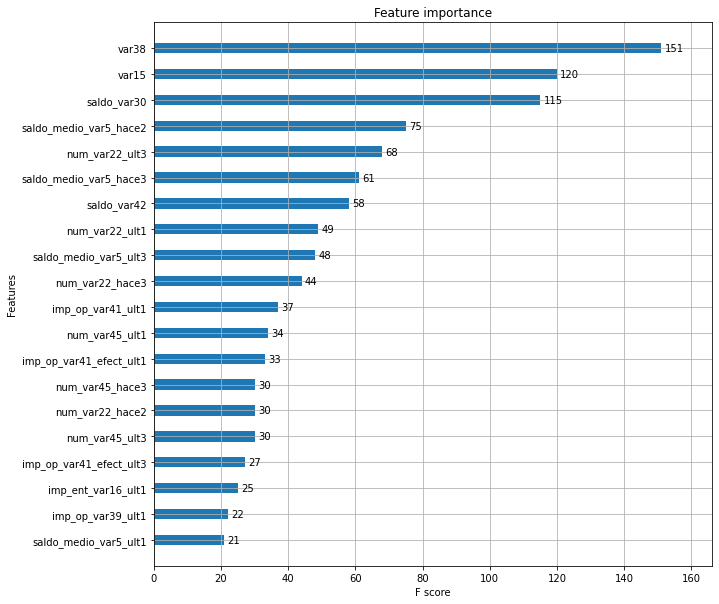

In [37]:
# 피처 중요도 시각화
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

ifg, ax = plt.subplots(figsize=(10,10))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

In [40]:
# LightGBM 모델 학습고 하이퍼 파라미터 튜닝
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimator=200)
evals = [(X_train,y_train)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=60, eval_metric='auc', eval_set=evals,verbose=True)
lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print(lgbm_roc_score)

[LightGBM] [Warning] Unknown parameter: n_estimator
[1]	training's auc: 0.823612	training's binary_logloss: 0.156016
Training until validation scores don't improve for 60 rounds
[2]	training's auc: 0.827661	training's binary_logloss: 0.150579
[3]	training's auc: 0.837671	training's binary_logloss: 0.146617
[4]	training's auc: 0.843171	training's binary_logloss: 0.143452
[5]	training's auc: 0.845828	training's binary_logloss: 0.140934
[6]	training's auc: 0.846531	training's binary_logloss: 0.138851
[7]	training's auc: 0.850239	training's binary_logloss: 0.136968
[8]	training's auc: 0.852495	training's binary_logloss: 0.135451
[9]	training's auc: 0.855269	training's binary_logloss: 0.134081
[10]	training's auc: 0.85682	training's binary_logloss: 0.132934
[11]	training's auc: 0.858637	training's binary_logloss: 0.131827
[12]	training's auc: 0.861098	training's binary_logloss: 0.130826
[13]	training's auc: 0.863058	training's binary_logloss: 0.129918
[14]	training's auc: 0.864903	training'

In [43]:
# GridSearchCV로 파라미터 튜닝
from sklearn.model_selection import GridSearchCV

# 테스트 수행 속도를 향상시키기 위해 n_estimator = 100으로 감소
lgbm_clf = LGBMClassifier(n_estimators=100)

params = {
    'num_leaves' :[32,64],
    'max_depth' :[128,160],
    'min_child_samples':[60,100],
    'subsample':[0.8,1]
}

#cv 는 3ㅡ로 가정
gridcv = GridSearchCV(lgbm_clf, param_grid = params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set = [(X_train, y_train), (X_test, y_test)])
print('최적 파라미터', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print(lgbm_roc_score)

[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	val

[32]	valid_0's auc: 0.875593	valid_0's binary_logloss: 0.123486	valid_1's auc: 0.838875	valid_1's binary_logloss: 0.139322
[33]	valid_0's auc: 0.8767	valid_0's binary_logloss: 0.123182	valid_1's auc: 0.838809	valid_1's binary_logloss: 0.139329
[34]	valid_0's auc: 0.87774	valid_0's binary_logloss: 0.122892	valid_1's auc: 0.838376	valid_1's binary_logloss: 0.139342
[35]	valid_0's auc: 0.878372	valid_0's binary_logloss: 0.122634	valid_1's auc: 0.838454	valid_1's binary_logloss: 0.13931
[36]	valid_0's auc: 0.879098	valid_0's binary_logloss: 0.122414	valid_1's auc: 0.838895	valid_1's binary_logloss: 0.13925
[37]	valid_0's auc: 0.879502	valid_0's binary_logloss: 0.122216	valid_1's auc: 0.838441	valid_1's binary_logloss: 0.139302
[38]	valid_0's auc: 0.880036	valid_0's binary_logloss: 0.121998	valid_1's auc: 0.838582	valid_1's binary_logloss: 0.139306
[39]	valid_0's auc: 0.880641	valid_0's binary_logloss: 0.121716	valid_1's auc: 0.838787	valid_1's binary_logloss: 0.139269
[40]	valid_0's auc: 0

[57]	valid_0's auc: 0.889157	valid_0's binary_logloss: 0.118369	valid_1's auc: 0.837585	valid_1's binary_logloss: 0.139447
[58]	valid_0's auc: 0.889659	valid_0's binary_logloss: 0.11819	valid_1's auc: 0.837789	valid_1's binary_logloss: 0.139431
Early stopping, best iteration is:
[28]	valid_0's auc: 0.87235	valid_0's binary_logloss: 0.12484	valid_1's auc: 0.840114	valid_1's binary_logloss: 0.139236
[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 

[27]	valid_0's auc: 0.871198	valid_0's binary_logloss: 0.124953	valid_1's auc: 0.838403	valid_1's binary_logloss: 0.139594
[28]	valid_0's auc: 0.872024	valid_0's binary_logloss: 0.124672	valid_1's auc: 0.838405	valid_1's binary_logloss: 0.139526
[29]	valid_0's auc: 0.873184	valid_0's binary_logloss: 0.124303	valid_1's auc: 0.838211	valid_1's binary_logloss: 0.139531
[30]	valid_0's auc: 0.874076	valid_0's binary_logloss: 0.12403	valid_1's auc: 0.838983	valid_1's binary_logloss: 0.139411
[31]	valid_0's auc: 0.874768	valid_0's binary_logloss: 0.123745	valid_1's auc: 0.839314	valid_1's binary_logloss: 0.139314
[32]	valid_0's auc: 0.875593	valid_0's binary_logloss: 0.123486	valid_1's auc: 0.838875	valid_1's binary_logloss: 0.139322
[33]	valid_0's auc: 0.8767	valid_0's binary_logloss: 0.123182	valid_1's auc: 0.838809	valid_1's binary_logloss: 0.139329
[34]	valid_0's auc: 0.87774	valid_0's binary_logloss: 0.122892	valid_1's auc: 0.838376	valid_1's binary_logloss: 0.139342
[35]	valid_0's auc: 

[55]	valid_0's auc: 0.888289	valid_0's binary_logloss: 0.118675	valid_1's auc: 0.837878	valid_1's binary_logloss: 0.139392
[56]	valid_0's auc: 0.888615	valid_0's binary_logloss: 0.118561	valid_1's auc: 0.837776	valid_1's binary_logloss: 0.139418
[57]	valid_0's auc: 0.889157	valid_0's binary_logloss: 0.118369	valid_1's auc: 0.837585	valid_1's binary_logloss: 0.139447
[58]	valid_0's auc: 0.889659	valid_0's binary_logloss: 0.11819	valid_1's auc: 0.837789	valid_1's binary_logloss: 0.139431
Early stopping, best iteration is:
[28]	valid_0's auc: 0.87235	valid_0's binary_logloss: 0.12484	valid_1's auc: 0.840114	valid_1's binary_logloss: 0.139236
[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logl

[22]	valid_0's auc: 0.883744	valid_0's binary_logloss: 0.121504	valid_1's auc: 0.834562	valid_1's binary_logloss: 0.140328
[23]	valid_0's auc: 0.885301	valid_0's binary_logloss: 0.12091	valid_1's auc: 0.835278	valid_1's binary_logloss: 0.140199
[24]	valid_0's auc: 0.886266	valid_0's binary_logloss: 0.120437	valid_1's auc: 0.835728	valid_1's binary_logloss: 0.140094
[25]	valid_0's auc: 0.88755	valid_0's binary_logloss: 0.119931	valid_1's auc: 0.836199	valid_1's binary_logloss: 0.140076
[26]	valid_0's auc: 0.888525	valid_0's binary_logloss: 0.119473	valid_1's auc: 0.836708	valid_1's binary_logloss: 0.139945
[27]	valid_0's auc: 0.889589	valid_0's binary_logloss: 0.119012	valid_1's auc: 0.836951	valid_1's binary_logloss: 0.139843
[28]	valid_0's auc: 0.890552	valid_0's binary_logloss: 0.118602	valid_1's auc: 0.836524	valid_1's binary_logloss: 0.139871
[29]	valid_0's auc: 0.891402	valid_0's binary_logloss: 0.118166	valid_1's auc: 0.836264	valid_1's binary_logloss: 0.139884
[30]	valid_0's auc

[49]	valid_0's auc: 0.902922	valid_0's binary_logloss: 0.111944	valid_1's auc: 0.835281	valid_1's binary_logloss: 0.140819
[50]	valid_0's auc: 0.903747	valid_0's binary_logloss: 0.111595	valid_1's auc: 0.835359	valid_1's binary_logloss: 0.140811
[51]	valid_0's auc: 0.904427	valid_0's binary_logloss: 0.111354	valid_1's auc: 0.835245	valid_1's binary_logloss: 0.140873
[52]	valid_0's auc: 0.90467	valid_0's binary_logloss: 0.111111	valid_1's auc: 0.835057	valid_1's binary_logloss: 0.140993
[53]	valid_0's auc: 0.904868	valid_0's binary_logloss: 0.110853	valid_1's auc: 0.834751	valid_1's binary_logloss: 0.14108
[54]	valid_0's auc: 0.905166	valid_0's binary_logloss: 0.110627	valid_1's auc: 0.83411	valid_1's binary_logloss: 0.141282
[55]	valid_0's auc: 0.905665	valid_0's binary_logloss: 0.110375	valid_1's auc: 0.833739	valid_1's binary_logloss: 0.141413
Early stopping, best iteration is:
[25]	valid_0's auc: 0.885234	valid_0's binary_logloss: 0.120268	valid_1's auc: 0.836722	valid_1's binary_lo

[23]	valid_0's auc: 0.885301	valid_0's binary_logloss: 0.12091	valid_1's auc: 0.835278	valid_1's binary_logloss: 0.140199
[24]	valid_0's auc: 0.886266	valid_0's binary_logloss: 0.120437	valid_1's auc: 0.835728	valid_1's binary_logloss: 0.140094
[25]	valid_0's auc: 0.88755	valid_0's binary_logloss: 0.119931	valid_1's auc: 0.836199	valid_1's binary_logloss: 0.140076
[26]	valid_0's auc: 0.888525	valid_0's binary_logloss: 0.119473	valid_1's auc: 0.836708	valid_1's binary_logloss: 0.139945
[27]	valid_0's auc: 0.889589	valid_0's binary_logloss: 0.119012	valid_1's auc: 0.836951	valid_1's binary_logloss: 0.139843
[28]	valid_0's auc: 0.890552	valid_0's binary_logloss: 0.118602	valid_1's auc: 0.836524	valid_1's binary_logloss: 0.139871
[29]	valid_0's auc: 0.891402	valid_0's binary_logloss: 0.118166	valid_1's auc: 0.836264	valid_1's binary_logloss: 0.139884
[30]	valid_0's auc: 0.891982	valid_0's binary_logloss: 0.117805	valid_1's auc: 0.835959	valid_1's binary_logloss: 0.139937
[31]	valid_0's auc

[49]	valid_0's auc: 0.902922	valid_0's binary_logloss: 0.111944	valid_1's auc: 0.835281	valid_1's binary_logloss: 0.140819
[50]	valid_0's auc: 0.903747	valid_0's binary_logloss: 0.111595	valid_1's auc: 0.835359	valid_1's binary_logloss: 0.140811
[51]	valid_0's auc: 0.904427	valid_0's binary_logloss: 0.111354	valid_1's auc: 0.835245	valid_1's binary_logloss: 0.140873
[52]	valid_0's auc: 0.90467	valid_0's binary_logloss: 0.111111	valid_1's auc: 0.835057	valid_1's binary_logloss: 0.140993
[53]	valid_0's auc: 0.904868	valid_0's binary_logloss: 0.110853	valid_1's auc: 0.834751	valid_1's binary_logloss: 0.14108
[54]	valid_0's auc: 0.905166	valid_0's binary_logloss: 0.110627	valid_1's auc: 0.83411	valid_1's binary_logloss: 0.141282
[55]	valid_0's auc: 0.905665	valid_0's binary_logloss: 0.110375	valid_1's auc: 0.833739	valid_1's binary_logloss: 0.141413
Early stopping, best iteration is:
[25]	valid_0's auc: 0.885234	valid_0's binary_logloss: 0.120268	valid_1's auc: 0.836722	valid_1's binary_lo

[18]	valid_0's auc: 0.861311	valid_0's binary_logloss: 0.129202	valid_1's auc: 0.83796	valid_1's binary_logloss: 0.140452
[19]	valid_0's auc: 0.862347	valid_0's binary_logloss: 0.128715	valid_1's auc: 0.838506	valid_1's binary_logloss: 0.140189
[20]	valid_0's auc: 0.86305	valid_0's binary_logloss: 0.128312	valid_1's auc: 0.837702	valid_1's binary_logloss: 0.140094
[21]	valid_0's auc: 0.863758	valid_0's binary_logloss: 0.127907	valid_1's auc: 0.838127	valid_1's binary_logloss: 0.139858
[22]	valid_0's auc: 0.864635	valid_0's binary_logloss: 0.127525	valid_1's auc: 0.838331	valid_1's binary_logloss: 0.139696
[23]	valid_0's auc: 0.865866	valid_0's binary_logloss: 0.127143	valid_1's auc: 0.837841	valid_1's binary_logloss: 0.139625
[24]	valid_0's auc: 0.867054	valid_0's binary_logloss: 0.126749	valid_1's auc: 0.838187	valid_1's binary_logloss: 0.139526
[25]	valid_0's auc: 0.867553	valid_0's binary_logloss: 0.126476	valid_1's auc: 0.838308	valid_1's binary_logloss: 0.13949
[26]	valid_0's auc:

[47]	valid_0's auc: 0.881591	valid_0's binary_logloss: 0.121422	valid_1's auc: 0.83861	valid_1's binary_logloss: 0.139687
[48]	valid_0's auc: 0.881867	valid_0's binary_logloss: 0.121266	valid_1's auc: 0.838593	valid_1's binary_logloss: 0.139682
[49]	valid_0's auc: 0.882285	valid_0's binary_logloss: 0.121041	valid_1's auc: 0.838317	valid_1's binary_logloss: 0.139741
[50]	valid_0's auc: 0.882828	valid_0's binary_logloss: 0.120853	valid_1's auc: 0.838244	valid_1's binary_logloss: 0.139759
[51]	valid_0's auc: 0.883154	valid_0's binary_logloss: 0.120688	valid_1's auc: 0.838222	valid_1's binary_logloss: 0.139803
[52]	valid_0's auc: 0.883348	valid_0's binary_logloss: 0.120567	valid_1's auc: 0.838064	valid_1's binary_logloss: 0.139824
[53]	valid_0's auc: 0.883583	valid_0's binary_logloss: 0.120424	valid_1's auc: 0.83788	valid_1's binary_logloss: 0.139844
[54]	valid_0's auc: 0.884106	valid_0's binary_logloss: 0.120208	valid_1's auc: 0.837625	valid_1's binary_logloss: 0.139886
[55]	valid_0's auc

[10]	valid_0's auc: 0.853922	valid_0's binary_logloss: 0.134622	valid_1's auc: 0.837333	valid_1's binary_logloss: 0.144318
[11]	valid_0's auc: 0.854729	valid_0's binary_logloss: 0.133702	valid_1's auc: 0.83725	valid_1's binary_logloss: 0.143512
[12]	valid_0's auc: 0.856303	valid_0's binary_logloss: 0.132789	valid_1's auc: 0.837602	valid_1's binary_logloss: 0.142833
[13]	valid_0's auc: 0.857206	valid_0's binary_logloss: 0.132038	valid_1's auc: 0.837364	valid_1's binary_logloss: 0.142245
[14]	valid_0's auc: 0.858161	valid_0's binary_logloss: 0.131391	valid_1's auc: 0.83777	valid_1's binary_logloss: 0.141759
[15]	valid_0's auc: 0.858975	valid_0's binary_logloss: 0.130772	valid_1's auc: 0.837831	valid_1's binary_logloss: 0.14139
[16]	valid_0's auc: 0.859623	valid_0's binary_logloss: 0.130219	valid_1's auc: 0.837953	valid_1's binary_logloss: 0.141016
[17]	valid_0's auc: 0.860576	valid_0's binary_logloss: 0.129684	valid_1's auc: 0.837985	valid_1's binary_logloss: 0.140713
[18]	valid_0's auc:

[40]	valid_0's auc: 0.878509	valid_0's binary_logloss: 0.122803	valid_1's auc: 0.838086	valid_1's binary_logloss: 0.139745
[41]	valid_0's auc: 0.879077	valid_0's binary_logloss: 0.122585	valid_1's auc: 0.838538	valid_1's binary_logloss: 0.139694
[42]	valid_0's auc: 0.879515	valid_0's binary_logloss: 0.122368	valid_1's auc: 0.838647	valid_1's binary_logloss: 0.139655
[43]	valid_0's auc: 0.879985	valid_0's binary_logloss: 0.122166	valid_1's auc: 0.838495	valid_1's binary_logloss: 0.139653
[44]	valid_0's auc: 0.88041	valid_0's binary_logloss: 0.121985	valid_1's auc: 0.838221	valid_1's binary_logloss: 0.139755
[45]	valid_0's auc: 0.880907	valid_0's binary_logloss: 0.121777	valid_1's auc: 0.837981	valid_1's binary_logloss: 0.139769
[46]	valid_0's auc: 0.881216	valid_0's binary_logloss: 0.121594	valid_1's auc: 0.838471	valid_1's binary_logloss: 0.139693
[47]	valid_0's auc: 0.881591	valid_0's binary_logloss: 0.121422	valid_1's auc: 0.83861	valid_1's binary_logloss: 0.139687
[48]	valid_0's auc

[7]	valid_0's auc: 0.861364	valid_0's binary_logloss: 0.136413	valid_1's auc: 0.837184	valid_1's binary_logloss: 0.146912
[8]	valid_0's auc: 0.862199	valid_0's binary_logloss: 0.134841	valid_1's auc: 0.837545	valid_1's binary_logloss: 0.145726
[9]	valid_0's auc: 0.864095	valid_0's binary_logloss: 0.133364	valid_1's auc: 0.837242	valid_1's binary_logloss: 0.144736
[10]	valid_0's auc: 0.866024	valid_0's binary_logloss: 0.132096	valid_1's auc: 0.837719	valid_1's binary_logloss: 0.143766
[11]	valid_0's auc: 0.867454	valid_0's binary_logloss: 0.131002	valid_1's auc: 0.837865	valid_1's binary_logloss: 0.143009
[12]	valid_0's auc: 0.868329	valid_0's binary_logloss: 0.130024	valid_1's auc: 0.837259	valid_1's binary_logloss: 0.14244
[13]	valid_0's auc: 0.869137	valid_0's binary_logloss: 0.129145	valid_1's auc: 0.837689	valid_1's binary_logloss: 0.141896
[14]	valid_0's auc: 0.870957	valid_0's binary_logloss: 0.128226	valid_1's auc: 0.838226	valid_1's binary_logloss: 0.141392
[15]	valid_0's auc: 

[29]	valid_0's auc: 0.886461	valid_0's binary_logloss: 0.120157	valid_1's auc: 0.837775	valid_1's binary_logloss: 0.140057
[30]	valid_0's auc: 0.887053	valid_0's binary_logloss: 0.119807	valid_1's auc: 0.837472	valid_1's binary_logloss: 0.140111
[31]	valid_0's auc: 0.888177	valid_0's binary_logloss: 0.119425	valid_1's auc: 0.837575	valid_1's binary_logloss: 0.140093
[32]	valid_0's auc: 0.889072	valid_0's binary_logloss: 0.119055	valid_1's auc: 0.837158	valid_1's binary_logloss: 0.140195
[33]	valid_0's auc: 0.889782	valid_0's binary_logloss: 0.118676	valid_1's auc: 0.837296	valid_1's binary_logloss: 0.140221
[34]	valid_0's auc: 0.890876	valid_0's binary_logloss: 0.118304	valid_1's auc: 0.837481	valid_1's binary_logloss: 0.140165
[35]	valid_0's auc: 0.891448	valid_0's binary_logloss: 0.11798	valid_1's auc: 0.837953	valid_1's binary_logloss: 0.140085
[36]	valid_0's auc: 0.892165	valid_0's binary_logloss: 0.11764	valid_1's auc: 0.837794	valid_1's binary_logloss: 0.140112
[37]	valid_0's auc

[37]	valid_0's auc: 0.892306	valid_0's binary_logloss: 0.117477	valid_1's auc: 0.828544	valid_1's binary_logloss: 0.141389
[38]	valid_0's auc: 0.892937	valid_0's binary_logloss: 0.117192	valid_1's auc: 0.827983	valid_1's binary_logloss: 0.141516
[39]	valid_0's auc: 0.893563	valid_0's binary_logloss: 0.116869	valid_1's auc: 0.828068	valid_1's binary_logloss: 0.141517
[40]	valid_0's auc: 0.893942	valid_0's binary_logloss: 0.11662	valid_1's auc: 0.827852	valid_1's binary_logloss: 0.141621
Early stopping, best iteration is:
[10]	valid_0's auc: 0.862964	valid_0's binary_logloss: 0.132331	valid_1's auc: 0.835026	valid_1's binary_logloss: 0.144789
[1]	valid_0's auc: 0.830474	valid_0's binary_logloss: 0.155928	valid_1's auc: 0.817343	valid_1's binary_logloss: 0.164928
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.842931	valid_0's binary_logloss: 0.1503	valid_1's auc: 0.82699	valid_1's binary_logloss: 0.15948
[3]	valid_0's auc: 0.850877	valid_0's binary_loglo

[18]	valid_0's auc: 0.875324	valid_0's binary_logloss: 0.125725	valid_1's auc: 0.834942	valid_1's binary_logloss: 0.141363
[19]	valid_0's auc: 0.876659	valid_0's binary_logloss: 0.125068	valid_1's auc: 0.835024	valid_1's binary_logloss: 0.141162
[20]	valid_0's auc: 0.877885	valid_0's binary_logloss: 0.124484	valid_1's auc: 0.835893	valid_1's binary_logloss: 0.140933
[21]	valid_0's auc: 0.879121	valid_0's binary_logloss: 0.12391	valid_1's auc: 0.837029	valid_1's binary_logloss: 0.140651
[22]	valid_0's auc: 0.880116	valid_0's binary_logloss: 0.123339	valid_1's auc: 0.837366	valid_1's binary_logloss: 0.140547
[23]	valid_0's auc: 0.881224	valid_0's binary_logloss: 0.12282	valid_1's auc: 0.837357	valid_1's binary_logloss: 0.140445
[24]	valid_0's auc: 0.882014	valid_0's binary_logloss: 0.122386	valid_1's auc: 0.837343	valid_1's binary_logloss: 0.140371
[25]	valid_0's auc: 0.88318	valid_0's binary_logloss: 0.121861	valid_1's auc: 0.83723	valid_1's binary_logloss: 0.140313
[26]	valid_0's auc: 

[29]	valid_0's auc: 0.873397	valid_0's binary_logloss: 0.124495	valid_1's auc: 0.833175	valid_1's binary_logloss: 0.140604
[30]	valid_0's auc: 0.87475	valid_0's binary_logloss: 0.12417	valid_1's auc: 0.833614	valid_1's binary_logloss: 0.140497
[31]	valid_0's auc: 0.875407	valid_0's binary_logloss: 0.12389	valid_1's auc: 0.833706	valid_1's binary_logloss: 0.140428
[32]	valid_0's auc: 0.876136	valid_0's binary_logloss: 0.123637	valid_1's auc: 0.833458	valid_1's binary_logloss: 0.140448
[33]	valid_0's auc: 0.876575	valid_0's binary_logloss: 0.123421	valid_1's auc: 0.832965	valid_1's binary_logloss: 0.140498
[34]	valid_0's auc: 0.877224	valid_0's binary_logloss: 0.123219	valid_1's auc: 0.832659	valid_1's binary_logloss: 0.140537
[35]	valid_0's auc: 0.877898	valid_0's binary_logloss: 0.122947	valid_1's auc: 0.832787	valid_1's binary_logloss: 0.140536
[36]	valid_0's auc: 0.878334	valid_0's binary_logloss: 0.122724	valid_1's auc: 0.832724	valid_1's binary_logloss: 0.14053
[37]	valid_0's auc: 

[19]	valid_0's auc: 0.86473	valid_0's binary_logloss: 0.128113	valid_1's auc: 0.838235	valid_1's binary_logloss: 0.140572
[20]	valid_0's auc: 0.865797	valid_0's binary_logloss: 0.127679	valid_1's auc: 0.838788	valid_1's binary_logloss: 0.140332
[21]	valid_0's auc: 0.866561	valid_0's binary_logloss: 0.127235	valid_1's auc: 0.839171	valid_1's binary_logloss: 0.140108
[22]	valid_0's auc: 0.867237	valid_0's binary_logloss: 0.12688	valid_1's auc: 0.839213	valid_1's binary_logloss: 0.13991
[23]	valid_0's auc: 0.867894	valid_0's binary_logloss: 0.126519	valid_1's auc: 0.839641	valid_1's binary_logloss: 0.139745
[24]	valid_0's auc: 0.868501	valid_0's binary_logloss: 0.126192	valid_1's auc: 0.840025	valid_1's binary_logloss: 0.139593
[25]	valid_0's auc: 0.869311	valid_0's binary_logloss: 0.125838	valid_1's auc: 0.839961	valid_1's binary_logloss: 0.139531
[26]	valid_0's auc: 0.870325	valid_0's binary_logloss: 0.125518	valid_1's auc: 0.839261	valid_1's binary_logloss: 0.139524
[27]	valid_0's auc:

[26]	valid_0's auc: 0.870183	valid_0's binary_logloss: 0.125414	valid_1's auc: 0.83333	valid_1's binary_logloss: 0.140724
[27]	valid_0's auc: 0.870926	valid_0's binary_logloss: 0.125123	valid_1's auc: 0.832503	valid_1's binary_logloss: 0.140772
[28]	valid_0's auc: 0.872431	valid_0's binary_logloss: 0.124766	valid_1's auc: 0.832826	valid_1's binary_logloss: 0.140685
[29]	valid_0's auc: 0.873397	valid_0's binary_logloss: 0.124495	valid_1's auc: 0.833175	valid_1's binary_logloss: 0.140604
[30]	valid_0's auc: 0.87475	valid_0's binary_logloss: 0.12417	valid_1's auc: 0.833614	valid_1's binary_logloss: 0.140497
[31]	valid_0's auc: 0.875407	valid_0's binary_logloss: 0.12389	valid_1's auc: 0.833706	valid_1's binary_logloss: 0.140428
[32]	valid_0's auc: 0.876136	valid_0's binary_logloss: 0.123637	valid_1's auc: 0.833458	valid_1's binary_logloss: 0.140448
[33]	valid_0's auc: 0.876575	valid_0's binary_logloss: 0.123421	valid_1's auc: 0.832965	valid_1's binary_logloss: 0.140498
[34]	valid_0's auc: 

[16]	valid_0's auc: 0.861239	valid_0's binary_logloss: 0.129765	valid_1's auc: 0.837374	valid_1's binary_logloss: 0.141537
[17]	valid_0's auc: 0.86217	valid_0's binary_logloss: 0.129164	valid_1's auc: 0.837703	valid_1's binary_logloss: 0.141192
[18]	valid_0's auc: 0.863228	valid_0's binary_logloss: 0.128615	valid_1's auc: 0.837526	valid_1's binary_logloss: 0.140917
[19]	valid_0's auc: 0.86473	valid_0's binary_logloss: 0.128113	valid_1's auc: 0.838235	valid_1's binary_logloss: 0.140572
[20]	valid_0's auc: 0.865797	valid_0's binary_logloss: 0.127679	valid_1's auc: 0.838788	valid_1's binary_logloss: 0.140332
[21]	valid_0's auc: 0.866561	valid_0's binary_logloss: 0.127235	valid_1's auc: 0.839171	valid_1's binary_logloss: 0.140108
[22]	valid_0's auc: 0.867237	valid_0's binary_logloss: 0.12688	valid_1's auc: 0.839213	valid_1's binary_logloss: 0.13991
[23]	valid_0's auc: 0.867894	valid_0's binary_logloss: 0.126519	valid_1's auc: 0.839641	valid_1's binary_logloss: 0.139745
[24]	valid_0's auc: 

[27]	valid_0's auc: 0.88664	valid_0's binary_logloss: 0.119673	valid_1's auc: 0.828869	valid_1's binary_logloss: 0.141682
[28]	valid_0's auc: 0.887143	valid_0's binary_logloss: 0.119308	valid_1's auc: 0.828987	valid_1's binary_logloss: 0.141649
[29]	valid_0's auc: 0.88825	valid_0's binary_logloss: 0.1189	valid_1's auc: 0.829075	valid_1's binary_logloss: 0.141601
[30]	valid_0's auc: 0.889081	valid_0's binary_logloss: 0.118531	valid_1's auc: 0.828871	valid_1's binary_logloss: 0.141605
[31]	valid_0's auc: 0.890195	valid_0's binary_logloss: 0.118117	valid_1's auc: 0.828972	valid_1's binary_logloss: 0.141605
[32]	valid_0's auc: 0.890928	valid_0's binary_logloss: 0.117735	valid_1's auc: 0.827969	valid_1's binary_logloss: 0.141796
[33]	valid_0's auc: 0.891505	valid_0's binary_logloss: 0.117389	valid_1's auc: 0.827611	valid_1's binary_logloss: 0.141916
[34]	valid_0's auc: 0.892223	valid_0's binary_logloss: 0.11707	valid_1's auc: 0.827019	valid_1's binary_logloss: 0.142051
[35]	valid_0's auc: 0

[13]	valid_0's auc: 0.870762	valid_0's binary_logloss: 0.128144	valid_1's auc: 0.83626	valid_1's binary_logloss: 0.142813
[14]	valid_0's auc: 0.872747	valid_0's binary_logloss: 0.127222	valid_1's auc: 0.835864	valid_1's binary_logloss: 0.142466
[15]	valid_0's auc: 0.874158	valid_0's binary_logloss: 0.126428	valid_1's auc: 0.83548	valid_1's binary_logloss: 0.142108
[16]	valid_0's auc: 0.875931	valid_0's binary_logloss: 0.125651	valid_1's auc: 0.836367	valid_1's binary_logloss: 0.141684
[17]	valid_0's auc: 0.876854	valid_0's binary_logloss: 0.124918	valid_1's auc: 0.835689	valid_1's binary_logloss: 0.141524
[18]	valid_0's auc: 0.878211	valid_0's binary_logloss: 0.124197	valid_1's auc: 0.835893	valid_1's binary_logloss: 0.141285
[19]	valid_0's auc: 0.879125	valid_0's binary_logloss: 0.123553	valid_1's auc: 0.835877	valid_1's binary_logloss: 0.141128
[20]	valid_0's auc: 0.880489	valid_0's binary_logloss: 0.122856	valid_1's auc: 0.835385	valid_1's binary_logloss: 0.141032
[21]	valid_0's auc

[25]	valid_0's auc: 0.884627	valid_0's binary_logloss: 0.120587	valid_1's auc: 0.82942	valid_1's binary_logloss: 0.141653
[26]	valid_0's auc: 0.885304	valid_0's binary_logloss: 0.120169	valid_1's auc: 0.828716	valid_1's binary_logloss: 0.141755
[27]	valid_0's auc: 0.88664	valid_0's binary_logloss: 0.119673	valid_1's auc: 0.828869	valid_1's binary_logloss: 0.141682
[28]	valid_0's auc: 0.887143	valid_0's binary_logloss: 0.119308	valid_1's auc: 0.828987	valid_1's binary_logloss: 0.141649
[29]	valid_0's auc: 0.88825	valid_0's binary_logloss: 0.1189	valid_1's auc: 0.829075	valid_1's binary_logloss: 0.141601
[30]	valid_0's auc: 0.889081	valid_0's binary_logloss: 0.118531	valid_1's auc: 0.828871	valid_1's binary_logloss: 0.141605
[31]	valid_0's auc: 0.890195	valid_0's binary_logloss: 0.118117	valid_1's auc: 0.828972	valid_1's binary_logloss: 0.141605
[32]	valid_0's auc: 0.890928	valid_0's binary_logloss: 0.117735	valid_1's auc: 0.827969	valid_1's binary_logloss: 0.141796
[33]	valid_0's auc: 0

[13]	valid_0's auc: 0.870762	valid_0's binary_logloss: 0.128144	valid_1's auc: 0.83626	valid_1's binary_logloss: 0.142813
[14]	valid_0's auc: 0.872747	valid_0's binary_logloss: 0.127222	valid_1's auc: 0.835864	valid_1's binary_logloss: 0.142466
[15]	valid_0's auc: 0.874158	valid_0's binary_logloss: 0.126428	valid_1's auc: 0.83548	valid_1's binary_logloss: 0.142108
[16]	valid_0's auc: 0.875931	valid_0's binary_logloss: 0.125651	valid_1's auc: 0.836367	valid_1's binary_logloss: 0.141684
[17]	valid_0's auc: 0.876854	valid_0's binary_logloss: 0.124918	valid_1's auc: 0.835689	valid_1's binary_logloss: 0.141524
[18]	valid_0's auc: 0.878211	valid_0's binary_logloss: 0.124197	valid_1's auc: 0.835893	valid_1's binary_logloss: 0.141285
[19]	valid_0's auc: 0.879125	valid_0's binary_logloss: 0.123553	valid_1's auc: 0.835877	valid_1's binary_logloss: 0.141128
[20]	valid_0's auc: 0.880489	valid_0's binary_logloss: 0.122856	valid_1's auc: 0.835385	valid_1's binary_logloss: 0.141032
[21]	valid_0's auc

[28]	valid_0's auc: 0.869304	valid_0's binary_logloss: 0.125764	valid_1's auc: 0.834935	valid_1's binary_logloss: 0.140287
[29]	valid_0's auc: 0.870037	valid_0's binary_logloss: 0.125514	valid_1's auc: 0.834481	valid_1's binary_logloss: 0.140258
[30]	valid_0's auc: 0.870785	valid_0's binary_logloss: 0.125254	valid_1's auc: 0.834179	valid_1's binary_logloss: 0.140275
[31]	valid_0's auc: 0.871706	valid_0's binary_logloss: 0.124992	valid_1's auc: 0.834475	valid_1's binary_logloss: 0.140205
[32]	valid_0's auc: 0.872582	valid_0's binary_logloss: 0.124728	valid_1's auc: 0.834353	valid_1's binary_logloss: 0.140189
[33]	valid_0's auc: 0.873445	valid_0's binary_logloss: 0.124481	valid_1's auc: 0.834592	valid_1's binary_logloss: 0.140082
[34]	valid_0's auc: 0.874095	valid_0's binary_logloss: 0.12426	valid_1's auc: 0.83436	valid_1's binary_logloss: 0.140101
[35]	valid_0's auc: 0.874869	valid_0's binary_logloss: 0.123982	valid_1's auc: 0.834045	valid_1's binary_logloss: 0.140151
[36]	valid_0's auc

[15]	valid_0's auc: 0.858907	valid_0's binary_logloss: 0.130878	valid_1's auc: 0.836329	valid_1's binary_logloss: 0.142383
[16]	valid_0's auc: 0.859887	valid_0's binary_logloss: 0.130287	valid_1's auc: 0.836611	valid_1's binary_logloss: 0.141883
[17]	valid_0's auc: 0.860889	valid_0's binary_logloss: 0.129757	valid_1's auc: 0.836848	valid_1's binary_logloss: 0.141535
[18]	valid_0's auc: 0.861827	valid_0's binary_logloss: 0.129301	valid_1's auc: 0.837106	valid_1's binary_logloss: 0.141257
[19]	valid_0's auc: 0.862972	valid_0's binary_logloss: 0.128826	valid_1's auc: 0.837185	valid_1's binary_logloss: 0.141043
[20]	valid_0's auc: 0.864083	valid_0's binary_logloss: 0.128369	valid_1's auc: 0.837509	valid_1's binary_logloss: 0.140794
[21]	valid_0's auc: 0.864747	valid_0's binary_logloss: 0.127959	valid_1's auc: 0.837888	valid_1's binary_logloss: 0.140626
[22]	valid_0's auc: 0.865769	valid_0's binary_logloss: 0.127562	valid_1's auc: 0.837811	valid_1's binary_logloss: 0.140487
[23]	valid_0's a

[23]	valid_0's auc: 0.865247	valid_0's binary_logloss: 0.127349	valid_1's auc: 0.834317	valid_1's binary_logloss: 0.140688
[24]	valid_0's auc: 0.865882	valid_0's binary_logloss: 0.12704	valid_1's auc: 0.833543	valid_1's binary_logloss: 0.14068
[25]	valid_0's auc: 0.867496	valid_0's binary_logloss: 0.126629	valid_1's auc: 0.834195	valid_1's binary_logloss: 0.140539
[26]	valid_0's auc: 0.867923	valid_0's binary_logloss: 0.126353	valid_1's auc: 0.834028	valid_1's binary_logloss: 0.140506
[27]	valid_0's auc: 0.868685	valid_0's binary_logloss: 0.126058	valid_1's auc: 0.834718	valid_1's binary_logloss: 0.140359
[28]	valid_0's auc: 0.869304	valid_0's binary_logloss: 0.125764	valid_1's auc: 0.834935	valid_1's binary_logloss: 0.140287
[29]	valid_0's auc: 0.870037	valid_0's binary_logloss: 0.125514	valid_1's auc: 0.834481	valid_1's binary_logloss: 0.140258
[30]	valid_0's auc: 0.870785	valid_0's binary_logloss: 0.125254	valid_1's auc: 0.834179	valid_1's binary_logloss: 0.140275
[31]	valid_0's auc

[8]	valid_0's auc: 0.846945	valid_0's binary_logloss: 0.137078	valid_1's auc: 0.834895	valid_1's binary_logloss: 0.146786
[9]	valid_0's auc: 0.849381	valid_0's binary_logloss: 0.135906	valid_1's auc: 0.834922	valid_1's binary_logloss: 0.145762
[10]	valid_0's auc: 0.850944	valid_0's binary_logloss: 0.134855	valid_1's auc: 0.835441	valid_1's binary_logloss: 0.144958
[11]	valid_0's auc: 0.852557	valid_0's binary_logloss: 0.133895	valid_1's auc: 0.835103	valid_1's binary_logloss: 0.144293
[12]	valid_0's auc: 0.854609	valid_0's binary_logloss: 0.133013	valid_1's auc: 0.835686	valid_1's binary_logloss: 0.143793
[13]	valid_0's auc: 0.855817	valid_0's binary_logloss: 0.132247	valid_1's auc: 0.835296	valid_1's binary_logloss: 0.143302
[14]	valid_0's auc: 0.857501	valid_0's binary_logloss: 0.131545	valid_1's auc: 0.836432	valid_1's binary_logloss: 0.142761
[15]	valid_0's auc: 0.858907	valid_0's binary_logloss: 0.130878	valid_1's auc: 0.836329	valid_1's binary_logloss: 0.142383
[16]	valid_0's auc

[13]	valid_0's auc: 0.867519	valid_0's binary_logloss: 0.129385	valid_1's auc: 0.833158	valid_1's binary_logloss: 0.143184
[14]	valid_0's auc: 0.869354	valid_0's binary_logloss: 0.128524	valid_1's auc: 0.833598	valid_1's binary_logloss: 0.142668
[15]	valid_0's auc: 0.870553	valid_0's binary_logloss: 0.127746	valid_1's auc: 0.833467	valid_1's binary_logloss: 0.142302
[16]	valid_0's auc: 0.871816	valid_0's binary_logloss: 0.126943	valid_1's auc: 0.83329	valid_1's binary_logloss: 0.142022
[17]	valid_0's auc: 0.872964	valid_0's binary_logloss: 0.126266	valid_1's auc: 0.83279	valid_1's binary_logloss: 0.141891
[18]	valid_0's auc: 0.874047	valid_0's binary_logloss: 0.125646	valid_1's auc: 0.831917	valid_1's binary_logloss: 0.141748
[19]	valid_0's auc: 0.875336	valid_0's binary_logloss: 0.125072	valid_1's auc: 0.831274	valid_1's binary_logloss: 0.141658
[20]	valid_0's auc: 0.876959	valid_0's binary_logloss: 0.124484	valid_1's auc: 0.831275	valid_1's binary_logloss: 0.141511
[21]	valid_0's auc

[41]	valid_0's auc: 0.897232	valid_0's binary_logloss: 0.115612	valid_1's auc: 0.836223	valid_1's binary_logloss: 0.139762
[42]	valid_0's auc: 0.897875	valid_0's binary_logloss: 0.11528	valid_1's auc: 0.836151	valid_1's binary_logloss: 0.139777
[43]	valid_0's auc: 0.898493	valid_0's binary_logloss: 0.114999	valid_1's auc: 0.836216	valid_1's binary_logloss: 0.139761
[44]	valid_0's auc: 0.899179	valid_0's binary_logloss: 0.114703	valid_1's auc: 0.836328	valid_1's binary_logloss: 0.139755
Early stopping, best iteration is:
[14]	valid_0's auc: 0.870957	valid_0's binary_logloss: 0.128226	valid_1's auc: 0.838226	valid_1's binary_logloss: 0.141392
[1]	valid_0's auc: 0.834724	valid_0's binary_logloss: 0.15607	valid_1's auc: 0.822983	valid_1's binary_logloss: 0.165104
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.842835	valid_0's binary_logloss: 0.150494	valid_1's auc: 0.830472	valid_1's binary_logloss: 0.159671
[3]	valid_0's auc: 0.847187	valid_0's binary_lo

[8]	valid_0's auc: 0.859479	valid_0's binary_logloss: 0.134947	valid_1's auc: 0.834093	valid_1's binary_logloss: 0.146607
[9]	valid_0's auc: 0.86143	valid_0's binary_logloss: 0.133519	valid_1's auc: 0.833898	valid_1's binary_logloss: 0.14559
[10]	valid_0's auc: 0.862964	valid_0's binary_logloss: 0.132331	valid_1's auc: 0.835026	valid_1's binary_logloss: 0.144789
[11]	valid_0's auc: 0.864277	valid_0's binary_logloss: 0.13126	valid_1's auc: 0.834957	valid_1's binary_logloss: 0.144152
[12]	valid_0's auc: 0.865572	valid_0's binary_logloss: 0.130304	valid_1's auc: 0.833693	valid_1's binary_logloss: 0.143697
[13]	valid_0's auc: 0.867519	valid_0's binary_logloss: 0.129385	valid_1's auc: 0.833158	valid_1's binary_logloss: 0.143184
[14]	valid_0's auc: 0.869354	valid_0's binary_logloss: 0.128524	valid_1's auc: 0.833598	valid_1's binary_logloss: 0.142668
[15]	valid_0's auc: 0.870553	valid_0's binary_logloss: 0.127746	valid_1's auc: 0.833467	valid_1's binary_logloss: 0.142302
[16]	valid_0's auc: 0

[34]	valid_0's auc: 0.892446	valid_0's binary_logloss: 0.117893	valid_1's auc: 0.836005	valid_1's binary_logloss: 0.139603
[35]	valid_0's auc: 0.893407	valid_0's binary_logloss: 0.11752	valid_1's auc: 0.8361	valid_1's binary_logloss: 0.139574
[36]	valid_0's auc: 0.893836	valid_0's binary_logloss: 0.117247	valid_1's auc: 0.836147	valid_1's binary_logloss: 0.139608
[37]	valid_0's auc: 0.894774	valid_0's binary_logloss: 0.116913	valid_1's auc: 0.836601	valid_1's binary_logloss: 0.139569
[38]	valid_0's auc: 0.895494	valid_0's binary_logloss: 0.116611	valid_1's auc: 0.836232	valid_1's binary_logloss: 0.139645
[39]	valid_0's auc: 0.896102	valid_0's binary_logloss: 0.116275	valid_1's auc: 0.836415	valid_1's binary_logloss: 0.139653
[40]	valid_0's auc: 0.896715	valid_0's binary_logloss: 0.115934	valid_1's auc: 0.836463	valid_1's binary_logloss: 0.139671
[41]	valid_0's auc: 0.897232	valid_0's binary_logloss: 0.115612	valid_1's auc: 0.836223	valid_1's binary_logloss: 0.139762
[42]	valid_0's auc:

[56]	valid_0's auc: 0.902162	valid_0's binary_logloss: 0.112169	valid_1's auc: 0.835965	valid_1's binary_logloss: 0.14086
[57]	valid_0's auc: 0.902422	valid_0's binary_logloss: 0.111944	valid_1's auc: 0.835493	valid_1's binary_logloss: 0.140993
Early stopping, best iteration is:
[27]	valid_0's auc: 0.884676	valid_0's binary_logloss: 0.121001	valid_1's auc: 0.838046	valid_1's binary_logloss: 0.140086
[1]	training's auc: 0.824305	training's binary_logloss: 0.156217	valid_1's auc: 0.819488	valid_1's binary_logloss: 0.165016
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.828798	training's binary_logloss: 0.150959	valid_1's auc: 0.822075	valid_1's binary_logloss: 0.159734
[3]	training's auc: 0.839609	training's binary_logloss: 0.147147	valid_1's auc: 0.829436	valid_1's binary_logloss: 0.156119
[4]	training's auc: 0.845158	training's binary_logloss: 0.144107	valid_1's auc: 0.836147	valid_1's binary_logloss: 0.153073
[5]	training's auc: 0.847711	training's 

In [48]:
# 최적 하이퍼 파라미터 적용
lgbm_clf = LGBMClassifier(n_estimators=200, num_leaves=32, subsample=0.8, min_child_samples=100, max_depth=128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_test, y_test, early_stopping_rounds=60, eval_metric = 'auc', eval_set=evals, verbose=True)
lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average = 'macro')
print(lgbm_roc_score)

[1]	training's auc: 0.852204	training's binary_logloss: 0.162716
Training until validation scores don't improve for 60 rounds
[2]	training's auc: 0.859496	training's binary_logloss: 0.156409
[3]	training's auc: 0.865478	training's binary_logloss: 0.151439
[4]	training's auc: 0.871147	training's binary_logloss: 0.147459
[5]	training's auc: 0.872291	training's binary_logloss: 0.14428
[6]	training's auc: 0.876005	training's binary_logloss: 0.141571
[7]	training's auc: 0.88005	training's binary_logloss: 0.13905
[8]	training's auc: 0.883683	training's binary_logloss: 0.13701
[9]	training's auc: 0.885416	training's binary_logloss: 0.135172
[10]	training's auc: 0.888285	training's binary_logloss: 0.133463
[11]	training's auc: 0.890981	training's binary_logloss: 0.131895
[12]	training's auc: 0.893151	training's binary_logloss: 0.130505
[13]	training's auc: 0.895585	training's binary_logloss: 0.129134
[14]	training's auc: 0.89814	training's binary_logloss: 0.127843
[15]	training's auc: 0.899683

[126]	training's auc: 0.971867	training's binary_logloss: 0.0795787
[127]	training's auc: 0.972121	training's binary_logloss: 0.0793575
[128]	training's auc: 0.972188	training's binary_logloss: 0.0792135
[129]	training's auc: 0.972265	training's binary_logloss: 0.0790557
[130]	training's auc: 0.972616	training's binary_logloss: 0.0788253
[131]	training's auc: 0.972752	training's binary_logloss: 0.0786283
[132]	training's auc: 0.972846	training's binary_logloss: 0.0784689
[133]	training's auc: 0.973391	training's binary_logloss: 0.0781208
[134]	training's auc: 0.973666	training's binary_logloss: 0.0778746
[135]	training's auc: 0.97385	training's binary_logloss: 0.0777
[136]	training's auc: 0.973902	training's binary_logloss: 0.0775546
[137]	training's auc: 0.973995	training's binary_logloss: 0.0773842
[138]	training's auc: 0.974265	training's binary_logloss: 0.0771319
[139]	training's auc: 0.974326	training's binary_logloss: 0.0769917
[140]	training's auc: 0.974397	training's binary_log

In [50]:
'''
IX. 분류 실습 - 캐글 신용카드 사기 검출
    - https://www.kaggle.com/mlg-ulb/creditcardfraud
    - 불균형데이터
    
    1. 언더 샘플링과 오버 샘플링의 이해
        - 지도학습에서 극도로 불균형한 레이블 값 분포로 인한 문제점을 해결하는 방법으로 오버 샘플링 방식이 예측 성능상 더 유리해 더 많이 사용
        - 언더 샘플링 : 많은 레이블을 가진 데이터를 적은 레이블을 가진 데이터 세트 수준으로 감소 
        - 오버 샘플링 : 적은 레이블을 가진 데이터를 많은 레이블을 가진 데이터 세트 수준으로 증식 ; 이 때 단순히 데이터만 늘리면 과적합 문제가 발생하므로 원본 피처 값을 아주 약간만 변경하여 증식
        - 오버 샘플링의 대표적인 방식은 SMOTE로 SMOTE는 K 최근접 이웃을 이용, 데이터를 증식 ; 파이썬 패키지 imbalanced-learn 이용 -> conda install -c conda-forge imbalanced-learn     
'''
#데이터 일차가공/ 모델학습 / 예측
import warnings
warnings.filterwarnings('ignore')

card_df = pd.read_csv('creditcard.csv')
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [54]:
#인자로 입력받은 DataFrame을 복사 뒤 불필요한 Time 칼럼을 삭제하는 함수 생성
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [55]:
# 데이터 가공 후 학습데이터와 테스트 데이터를 반환하는 함수 생성
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [57]:
# 레이블 비율 확인
print('학습 데이터 레이블 비율 :\n', y_train.value_counts()/y_train.shape[0] *100)
print('테스트 데이터 레이블 비율 :\n', y_test.value_counts()/y_test.shape[0] *100)

학습 데이터 레이블 비율 :
 0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 비율 :
 0    99.826785
1     0.173215
Name: Class, dtype: float64


In [61]:
#로지스틱 회귀 모델 생성
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

def get_clf_eval(y_test, pred=None, pred_proba=None):
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, AUC:0.9611


In [64]:
# LightGBM 모델 생성
# 인자로 사이킷런의 Estimator객체와 학습/테스트 데이터 세트를 입력받아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    
    def get_clf_eval(y_test, pred=None, pred_proba=None):
        from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
        confusion = confusion_matrix( y_test, pred)
        accuracy = accuracy_score(y_test , pred)
        precision = precision_score(y_test , pred)
        recall = recall_score(y_test , pred)
        f1 = f1_score(y_test,pred)
        # ROC-AUC 추가 
        roc_auc = roc_auc_score(y_test, pred_proba)
        print('오차 행렬')
        print(confusion)
        # ROC-AUC print 추가
        print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    
    get_clf_eval(tgt_test, pred, pred_proba)

from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators=200, num_leaves=64, n_jobs=-1, boost_from_average=False) #불균형데이터를 LightGBM으로 추정시 디폴트가 True인 boost_from_avrage를 False로 반드시 바꿔야 올바르게 모델 추정 가능
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500, F1: 0.8409, AUC:0.9799


<AxesSubplot:xlabel='Amount', ylabel='Density'>

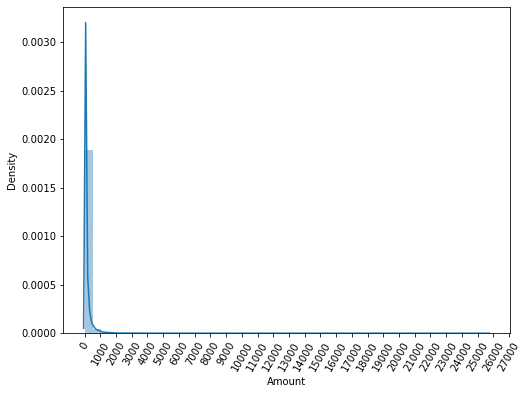

In [68]:
'''
    2. 데이터 분포도 변환 후 모델 학습/예측/평가
'''

# 로지스틱 회귀는 데이터가 정규분포일 때 효율적
# Amount 피처의 분포 확인
import seaborn as sns
plt.figure(figsize=(8,6))
plt.xticks(range(0,30000,1000), rotation=60)
sns.distplot(card_df['Amount'])

In [71]:
# Amount를 표준 정규분포형태로 변환 뒤 로지스틱 회귀 예측
from sklearn.preprocessing import StandardScaler

#함수 생성
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    df_copy.insert(0, 'Amount_Scaled', amount_n) # DataFrame의 맨 앞 칼럼에 Amount_Scaled란 피처명으로 입력
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

# Amount를 정규분포로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('##로지스틱 회귀 수행##')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('##LightGBM 수행##')
lgbm_clf = LGBMClassifier(n_estimators = 500, num_leaves=64, n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
#성능이 크게 개선되지는 않았음

##로지스틱 회귀 수행##
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, AUC:0.9702
##LightGBM 수행##
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500, F1: 0.8409, AUC:0.9792


In [72]:
# StandardScaler 대신 로그변환 수행
# 로그 변환은 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 주요 기법 중 하나로 원래값을 log값으로 변환해 왜곡도를 개선 -> 넘파이의 log1p()함수를 이용

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'],axis=1,inplace=True)
    return df_copy

# Amount를 로그 스케일링 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('##로지스틱 회귀 수행##')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('##LightGBM 수행##')
lgbm_clf = LGBMClassifier(n_estimators = 500, num_leaves=64, n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
#성능 약간씩 개선

##로지스틱 회귀 수행##
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, AUC:0.9727
##LightGBM 수행##
오차 행렬
[[85291     4]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9658, 재현율: 0.7635, F1: 0.8528, AUC:0.9790


<AxesSubplot:>

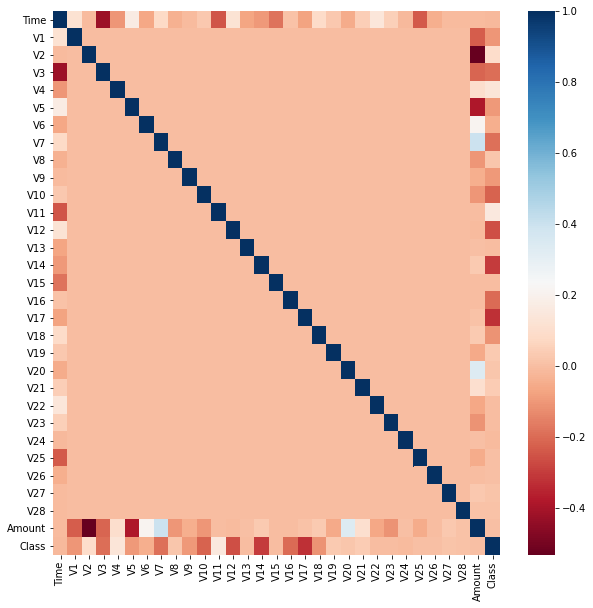

In [73]:
'''
    3. 이상치 데이터(Outlier) 제거 후 모델 학습/예측/평가
        - IQR 방식으로 이상치 탐지, IQR은 25% ~ 75%의 구간
        - 보통 IQR에 1.5를 곱해서 생성된 범위를 이용, 최대값과 최솟값을 결정한 뒤 이상치를 탐지 ; Q1에 IQR*1.5를 빼서 최솟값, Q3에 IQR*1.5를 더해서 최대값을 만듬
        - 이를 시각화 한 것이 박스플롯        
'''

# 이상치를 제거할 피처는 레이블과 가장 상관성이 높은 데이터로 하는 것이 좋음 -> 상관도 구한 후 결정
plt.figure(figsize=(10,10))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [75]:
# V14에 대한 이상치를 제거하는 함수 생성
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud<lowest_val) | (fraud>highest_val)].index
    return outlier_index

outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 인덱스 :', outlier_index)

이상치 인덱스 : Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [77]:
# 아웃라이어를 삭제하는 로직을 get_processed_df()에 추가
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'],axis=1,inplace=True)
    
    #이상치 삭제
    def get_outlier(df=None, column=None, weight=1.5):
        fraud = df[df['Class']==1][column]
        quantile_25 = np.percentile(fraud.values, 25)
        quantile_75 = np.percentile(fraud.values, 75)

        iqr = quantile_75 - quantile_25
        iqr_weight = iqr * weight
        lowest_val = quantile_25 - iqr_weight
        highest_val = quantile_75 + iqr_weight

        outlier_index = fraud[(fraud<lowest_val) | (fraud>highest_val)].index
        return outlier_index
    
    outlier_index = get_outlier(df=df_copy, column='V14', weight= 1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('##로지스틱 회귀 수행##')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('##LightGBM 수행##')
lgbm_clf = LGBMClassifier(n_estimators = 500, num_leaves=64, n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
# 성능 크게 향상

##로지스틱 회귀 수행##
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC:0.9743
##LightGBM 수행##
오차 행렬
[[85290     5]
 [   26   120]]
정확도: 0.9996, 정밀도: 0.9600, 재현율: 0.8219, F1: 0.8856, AUC:0.9774


In [78]:
# SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가
# 오버 샘플링은 반드시 학습 데이터 세트에서만 시행

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('적용 전 :', X_train.shape, y_train.shape)
print('적용 후 :', X_train_over.shape, y_train_over.shape)
print('적용 후 데이터 분포 :\n', pd.Series(y_train_over).value_counts())

적용 전 : (199362, 29) (199362,)
적용 후 : (398040, 29) (398040,)
적용 후 데이터 분포 :
 1    199020
0    199020
Name: Class, dtype: int64


In [80]:
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)
#오버 샘플링으로 실제보다 많은 Class=1을 학습하면서 정밀도가 크게 하락

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, F1: 0.1023, AUC:0.9737


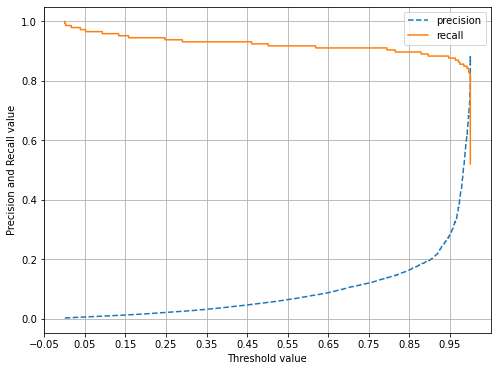

In [83]:
# 정밀도-재현율 시각화

def precision_recall_curve_plot(y_test , pred_proba_c1):
    from sklearn.metrics import precision_recall_curve
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

In [85]:
# 로지스틱 회귀의 경우 임계값의 민감도가 너무 심해 SMOTE 적용 후 올바른 예측모델 생성 X

#LightGBM 모델 학습
lgbm_clf = LGBMClassifier(n_estimators=200, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train = X_train_over, ftr_test = X_test, tgt_train = y_train_over, tgt_test = y_test)
# 재현율은 상승하고 정밀도는 하락(SMOTE를 적용시 일반적인 현상)

오차 행렬
[[85281    14]
 [   21   125]]
정확도: 0.9996, 정밀도: 0.8993, 재현율: 0.8562, F1: 0.8772, AUC:0.9792


In [87]:
'''
X. 스태킹 앙상블
    - 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행(메타모델)
    - 두 종류의 모델이 필요 : 개별적인 기반모델과 이 개별 기반 모델의 예측데이터를 학습 데이터로 만들어서 학습하는 최종 메타모델
'''
# 기본 스태킹 모델
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()
X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

# 개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 스태킹으로 만들어진 데이터를 학습, 예측할 최종 모델
lr_final = LogisticRegression(C=10)

# 개별 모델들을 학습
knn_clf.fit(X_train,y_train)
rf_clf.fit(X_train,y_train)
dt_clf.fit(X_train,y_train)
ada_clf.fit(X_train,y_train)

# 학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('##개별모델 정확성##')
print('KNN :', accuracy_score(y_test, knn_pred))
print('Radom Forest :', accuracy_score(y_test, rf_pred))
print('Decision Tree :', accuracy_score(y_test, dt_pred))
print('Ada Boost :', accuracy_score(y_test, ada_pred))


##개별모델 정확성##
KNN : 0.9210526315789473
Radom Forest : 0.9649122807017544
Decision Tree : 0.9122807017543859
Ada Boost : 0.956140350877193


In [89]:
# 예측 데이터 붙이기
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [90]:
# 최종 학습

lr_final.fit(pred, y_test)
final = lr_final.predict(pred)
print(accuracy_score(y_test, final))

0.9736842105263158


In [93]:
'''
    1. CV 세트 기반의 스태킹
        - 과적합을 개선하기 위해 최종 메타 모델을 위한 데이터 세트를 만들 때 교차 검증 기반으로 예측된 결과 데이터 세트를 이용 (최종 학습시 이용하는 것이 테스트용 데이터 기반이므로 과적합 문제 발생 가능)
        - 스텝 1: 각 모델별로 원본 학습/테스트 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터 생성
            - 개별 모델의 검증 데이터 예측값을 모음(n차 교차검증이면 n개의 묶음이 나옴)-> 하나로 쌓음  -> 각 모델의 검증 데이터 예측값 모음을 다시 모아 최종모델의 학습데이터로 사용
            - 개별 모델의 테스트 데이터 예측값을 모음('')-> 이를 평균내서 한개의 테스트 데이터 마련 -> 각 모델의 테스트 데이터 예측값 모음을 다시 모아서 최종모델의 테스트 데이터로 사용
        - 스텝 2: 스텝 1에서 개별 모델들이 생성한 데이터들을 합쳐서 메타모델 학습/ 예측
'''
# 스텝 1
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#개별 기반 모델에서 최종 메타모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    # 지정된 n_folds 값으로 KFold 생성
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    #추후에 메타모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, 'model 시작')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 추출
        print('\t 폴드 세트: ', folder_counter, '시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델 학습 수행
        model.fit(X_tr, y_tr)
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)
    
    #폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    #train_fold_pred는 최종 메타모델이 사용하는 학습데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean


In [100]:
# 각 모델별로 데이터 생성
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf,X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

#스텝 2
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)

print('원본 데이터 크기 :', X_train.shape, X_test.shape)
print('스태킹 데이터 크기 :', Stack_final_X_train.shape, Stack_final_X_test.shape)

KNeighborsClassifier model 시작
	 폴드 세트:  0 시작 
	 폴드 세트:  1 시작 
	 폴드 세트:  2 시작 
	 폴드 세트:  3 시작 
	 폴드 세트:  4 시작 
	 폴드 세트:  5 시작 
	 폴드 세트:  6 시작 
RandomForestClassifier model 시작
	 폴드 세트:  0 시작 
	 폴드 세트:  1 시작 
	 폴드 세트:  2 시작 
	 폴드 세트:  3 시작 
	 폴드 세트:  4 시작 
	 폴드 세트:  5 시작 
	 폴드 세트:  6 시작 
DecisionTreeClassifier model 시작
	 폴드 세트:  0 시작 
	 폴드 세트:  1 시작 
	 폴드 세트:  2 시작 
	 폴드 세트:  3 시작 
	 폴드 세트:  4 시작 
	 폴드 세트:  5 시작 
	 폴드 세트:  6 시작 
AdaBoostClassifier model 시작
	 폴드 세트:  0 시작 
	 폴드 세트:  1 시작 
	 폴드 세트:  2 시작 
	 폴드 세트:  3 시작 
	 폴드 세트:  4 시작 
	 폴드 세트:  5 시작 
	 폴드 세트:  6 시작 
원본 데이터 크기 : (455, 30) (114, 30)
스태킹 데이터 크기 : (455, 4) (114, 4)


In [101]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)
print(accuracy_score(y_test, stack_final))
# 여기선 그러지 않았지만 각각의 모델들을 튜닝 후 스태킹 하는 것이 일반적

0.9736842105263158
